<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#prepare-data-for-fit" data-toc-modified-id="prepare-data-for-fit-1">prepare data for fit</a></span></li><li><span><a href="#stochasticity-effect" data-toc-modified-id="stochasticity-effect-2">stochasticity effect</a></span><ul class="toc-item"><li><span><a href="#reset-graph-and-model" data-toc-modified-id="reset-graph-and-model-2.1">reset graph and model</a></span></li><li><span><a href="#reload-past-runs" data-toc-modified-id="reload-past-runs-2.2">reload past runs</a></span></li><li><span><a href="#analysis-of-goodness-of-fit" data-toc-modified-id="analysis-of-goodness-of-fit-2.3">analysis of goodness of fit</a></span></li><li><span><a href="#(static)-plot" data-toc-modified-id="(static)-plot-2.4">(static) plot</a></span></li><li><span><a href="#interactive-plot" data-toc-modified-id="interactive-plot-2.5"><strong>interactive</strong> plot</a></span></li></ul></li><li><span><a href="#parameters-estimation" data-toc-modified-id="parameters-estimation-3">parameters estimation</a></span><ul class="toc-item"><li><span><a href="#model-and-error-functions" data-toc-modified-id="model-and-error-functions-3.1">model and error functions</a></span></li><li><span><a href="#differential_evolution" data-toc-modified-id="differential_evolution-3.2"><code>differential_evolution</code></a></span><ul class="toc-item"><li><span><a href="#nested-parallelization" data-toc-modified-id="nested-parallelization-3.2.1">nested parallelization</a></span></li><li><span><a href="#external-parallelization-only" data-toc-modified-id="external-parallelization-only-3.2.2">external parallelization only</a></span></li></ul></li><li><span><a href="#plot-data-with-fitted-model" data-toc-modified-id="plot-data-with-fitted-model-3.3">plot data with fitted model</a></span></li></ul></li><li><span><a href="#behavioral-$\beta$--v." data-toc-modified-id="behavioral-$\beta$--v.-4">behavioral $\beta$  v.</a></span><ul class="toc-item"><li><span><a href="#define-and-test-model" data-toc-modified-id="define-and-test-model-4.1">define and test model</a></span></li><li><span><a href="#plot-multi-runs" data-toc-modified-id="plot-multi-runs-4.2">plot multi runs</a></span></li></ul></li><li><span><a href="#EXTRAS" data-toc-modified-id="EXTRAS-5">EXTRAS</a></span><ul class="toc-item"><li><span><a href="#reproduce-small-word-topology" data-toc-modified-id="reproduce-small-word-topology-5.1">reproduce small word topology</a></span></li><li><span><a href="#graph-topology-effect" data-toc-modified-id="graph-topology-effect-5.2">graph-topology effect</a></span></li><li><span><a href="#community-structure-effect" data-toc-modified-id="community-structure-effect-5.3">community-structure effect</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

# modules for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')


import networkx as nx

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# module to save space
import gc

possible module for simulating epidemics on networks

- [NDlib](https://ndlib.readthedocs.io/en/latest/)
- [EoN](https://epidemicsonnetworks.readthedocs.io/en/latest/EoN.html) 
- [epydemic](https://pythonhosted.org/epydemic/)


here we use `NDlib` -- we follow the workflow of [this tutorial](https://colab.research.google.com/github/KDDComplexNetworkAnalysis/CNA_Tutorials/blob/master/NDlib.ipynb#scrollTo=5d6GMqEdTU2L)

In [2]:
from ndlib.models import epidemics
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

from ndlib.utils import multi_runs

# prepare data for fit

import dataset at city level, with baseline already removed! 

check that dataset has no gaps in dates: 1 days    1094
dtype: int64
(400,)
1630-08-24 00:00:00    0.0
1630-08-25 00:00:00    0.0
1630-08-26 00:00:00    0.0
1630-08-27 00:00:00    0.0
1630-08-28 00:00:00    0.0
Name: counts, dtype: float64


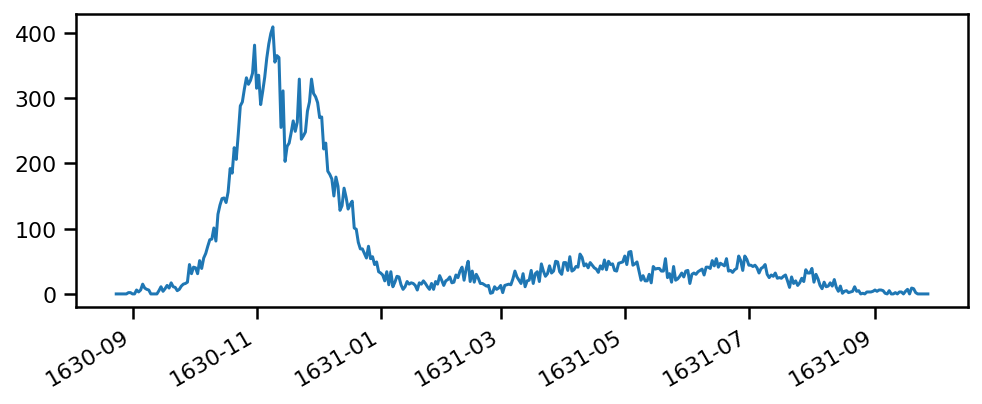

In [9]:
data_to_fit = pd.read_csv('./dataset/city_cases_baseline_removed.csv',
                          index_col=0)
data_to_fit.columns = ['counts']
data_to_fit.head()

# parsing dates
data_to_fit.index = [datetime.strptime(my_idx.split()[0], '%Y-%m-%d')
                     for my_idx in data_to_fit.index]

# move to simple series
data_to_fit = pd.Series(data_to_fit.counts)

# this dataset has no gaps in dates! -- as expected
print('check that dataset has no gaps in dates:',
      pd.Series(np.diff(data_to_fit.index)).value_counts())

city_start = datetime(1630, 8, 24)
data_to_fit = data_to_fit[city_start:(city_start + timedelta(399))]

print(data_to_fit.shape)
print(data_to_fit.head())

data_to_fit.plot(figsize=(8, 3))
# plt.xticks(rotation=0)
plt.show()

# stochasticity effect

in this section we mainly plot results from fitting experiments, exploring variability of simulated runs (due to stochasticity in network)

## reset graph and model 

WS graph generation 

(you can see in the [extra section: #reproduce-small-word-topology](http://localhost:8888/notebooks/TO_BE_CLEANED_epid_simulations.ipynb#reproduce-small-word-topology)
the rationale behind the choice for the value (`0.04`) for the rewiring probability)

In [5]:
# n_nodes = 5247
n_nodes = 140000
nnn = 5  # N. nearest neighbours
%time g = nx.watts_strogatz_graph(n_nodes, nnn, 0.04)

# g = nx.watts_strogatz_graph(n_nodes, nnn, best_rew_pro)
# g = nx.watts_strogatz_graph(n_nodes, nnn, best_fit.x[0])

CPU times: user 595 ms, sys: 32.8 ms, total: 628 ms
Wall time: 627 ms


ER graph generation -- [mind ER properties](https://en.wikipedia.org/wiki/Erdős–Rényi_model#Properties_of_G(n,_p))

In [4]:
# n_nodes = 5500  # here the N nodes is higher as we want to pass a giant c.c. with similar N, but still with 'low' <k> ~ 4
n_nodes = 20000  # 140000 # 50000 # 10000
prob_edge = 4 / n_nodes  # 3.27/ n_nodes
print(prob_edge * n_nodes)

%time g = nx.fast_gnp_random_graph(n_nodes, prob_edge)

4.0
CPU times: user 137 ms, sys: 8.42 ms, total: 146 ms
Wall time: 144 ms


quick network analysis

In [6]:
print('N. edges:', nx.number_of_edges(g))
print('N. nodes:', nx.number_of_nodes(g))
print('N. connected components:', nx.number_connected_components(g))

degrees = list(dict(g.degree()).values())
print('mean degree:', np.mean(degrees))

print('Average clus. coeff.:', nx.average_clustering(g))

N. edges: 280000
N. nodes: 140000
N. connected components: 1
mean degree: 4.0
Average clus. coeff.: 0.44583738095249814


it takes too long to compute communities for large (n = 140k) graphs (skip it)

In [ ]:
my_comm = nx.community.greedy_modularity_communities(g)
### ...there are other ways to compute communities -- e.g. # len(nx.community.asyn_lpa_communities(g)) # this is quite slow

print('N. modularity-based-communities:', len(my_comm))
print('graph modularity:', nx.community.modularity(g, my_comm))

set model class and initial parameters values (from previous fitting experiments)

In [7]:
model = epidemics.SIRModel(g)  ## for the latest v.

cfg = mc.Configuration()

# results = [4.71818600e-01, 7.57240146e-01, 8.73582950e-05]
# results  =  [4.97024567e-01, 8.54549412e-01, 9.80649558e-05]

## from fit on 2timesteps, tol=0.05
results = [4.87669804e-01, 8.29038768e-01, 2.06927577e-05]

cfg.add_model_parameter('beta', results[0])
cfg.add_model_parameter('gamma', results[1])
cfg.add_model_parameter('fraction_infected', results[2])

model.set_initial_status(cfg)
model.get_info()

{'beta': 0.487669804,
 'gamma': 0.829038768,
 'fraction_infected': 2.06927577e-05,
 'tp_rate': 1}

(very long) run bulk/single simulations and visualize results

In [10]:
%%time

trends = multi_runs(
    model=model, execution_number=180, iteration_number=800, nprocesses=45)

# iterations = model.iteration_bunch(400, node_status=True)
# trends = model.build_trends(iterations)

CPU times: user 6min 24s, sys: 58.7 s, total: 7min 23s
Wall time: 49min 45s


## reload past runs 

In [ ]:
removed_inc_v1 = pd.read_csv(
    'simulations_plots/trends_2timesteps_0.48767_0.829039_2.1e-05.csv',
    index_col=0)
removed_inc_v2 = pd.read_csv(
    'simulations_plots/trends_2timesteps_0.48767_0.829039_2.1e-05_v2.csv',
    index_col=0)
removed_inc_v3 = pd.read_csv(
    'simulations_plots/trends_2timesteps_0.48767_0.829039_2.1e-05_v3.csv',
    index_col=0)
removed_inc_v4 = pd.read_csv(
    'simulations_plots/trends_2timesteps_0.48767_0.829039_2.1e-05_v4.csv',
    index_col=0)

removed_inc = pd.concat(
    [removed_inc_v1, removed_inc_v2, removed_inc_v3, removed_inc_v4],
    ignore_index=True)

# save space
del removed_inc_v1, removed_inc_v2, removed_inc_v3, removed_inc_v4
gc.collect()

In [11]:
# removed_inc = pd.read_csv('simulations_plots/trends_0.531261136_1_0.000331151161.csv')
# removed_inc = pd.read_csv('simulations_plots/trends_0.471819_0.75724_8.7e-05.csv')
# removed_inc = pd.read_csv('simulations_plots/trends_0.497025_0.854549_9.8e-05.csv')

# mind that in this output data was already aggregated by 2ts
removed_inc = pd.read_csv('simulations_plots/trends_2timesteps_0.48767_0.829039_2.1e-05_N_3600.csv',index_col=0)

# fix col type
removed_inc.columns = [int(i) for i in removed_inc.columns]

print(removed_inc.shape)
removed_inc.head()

## for the large dataset (N=3600), data were already aggregated
grouped_remov_inc = removed_inc.copy()
del removed_inc
gc.collect()

(400, 3600)


0

In [72]:
# these are runs from sims on ER!! after best fit, also computed on the ICCluster!
removed_inc_v1 = pd.read_csv('simulations_plots/trends_ER_0.238153_0.852766_8.1e-05_v1.csv',index_col=0).transpose()
removed_inc_v2 = pd.read_csv('simulations_plots/trends_ER_0.238153_0.852766_8.1e-05_v2.csv',index_col=0).transpose()
removed_inc_v3 = pd.read_csv('simulations_plots/trends_ER_0.238153_0.852766_8.1e-05_N_1800_v3.csv',index_col=0)
removed_inc_v4 = pd.read_csv('simulations_plots/trends_ER_0.238153_0.852766_8.1e-05_N_1800_v4.csv',index_col=0)

# fix index type - set it the same as the other csv
removed_inc_v1.index = removed_inc_v1.index.astype('int64')
removed_inc_v2.index = removed_inc_v1.index.astype('int64')

# concat all csv
removed_inc = pd.concat([removed_inc_v1,removed_inc_v2,removed_inc_v3,removed_inc_v4],axis=1,ignore_index=True)

# save space
del removed_inc_v1, removed_inc_v2, removed_inc_v3, removed_inc_v4
gc.collect();

( this was previous code >> _extract_ removed incidence from total results -- in case data was produced here (and not loaded))

In [ ]:
removed_inc = pd.DataFrame([t['trends']['status_delta'][2] for t in trends])
# infected_inc = pd.DataFrame([t['trends']['status_delta'][1] for t in trends])
# susc_inc = pd.DataFrame([t['trends']['status_delta'][0] for t in trends])

del trends  # save some space
gc.collect()

__aggregate__ (each 2) time steps

In [4]:
## aggregate over 2 timesteps!!
removed_inc_t = removed_inc.transpose()
grouped_remov_inc = removed_inc_t.groupby(removed_inc_t.index // 2).sum()
print(grouped_remov_inc.shape)

del removed_inc_t, removed_inc  # save some space
gc.collect()

(1800, 400)


save new dataframe to file

In [14]:
## save removed_inc in case you wanna change the plot
# results = [0.531261136,1,0.000331151161]
# results = [5.25614858e-01, 9.73085945e-01, 5.37997920e-05]

# removed_inc.to_csv('./trends_{}_{}_{}.csv'.format(*[np.round(p,6) for p in results]))
removed_inc.to_csv('./trends_2timesteps_{}_{}_{}_v4.csv'.format(
    *[np.round(p, 6) for p in results]))

## analysis of goodness of fit

these are analysis of fit of model runs on __ER__ graph

simple RMSE

In [ ]:
from sklearn.metrics import mean_squared_error

rmse_list =  removed_inc.apply(lambda y: np.sqrt(mean_squared_error(y,data_to_fit)))
print('best run -- lowest rmse', rmse_list.idxmin(), rmse_list.min())

dynamic-time-warp-based distance

In [75]:
from fastdtw import fastdtw

%time dtwd_list = removed_inc.apply(lambda y: fastdtw(y,data_to_fit)[0])

CPU times: user 1.49 s, sys: 17.6 ms, total: 1.51 s
Wall time: 1.5 s


linear correlation

In [76]:
corrd_list = removed_inc.apply(
    lambda y: np.corrcoef(y, data_to_fit)[0, 1])

metrics hist and corr

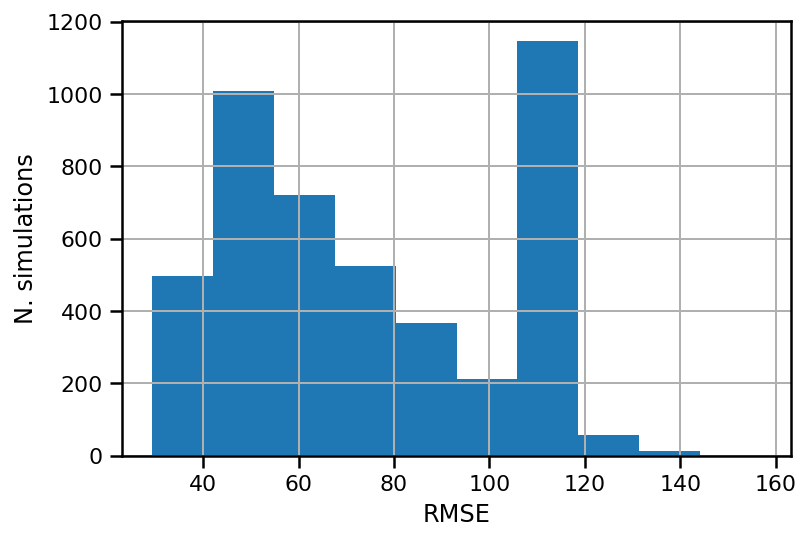

In [77]:
rmse_list.hist()

plt.xlabel('RMSE')
plt.ylabel('N. simulations');

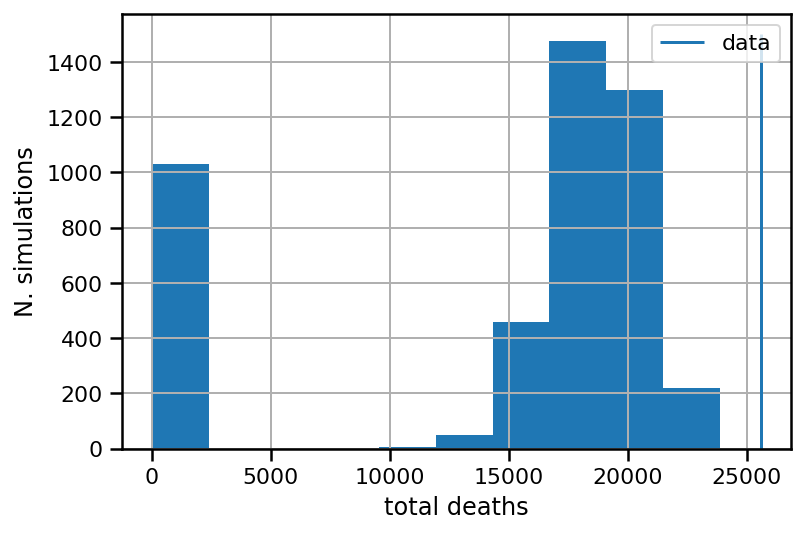

In [78]:
removed_inc.sum().hist()
plt.vlines(x=data_to_fit.sum(), ymin=0, ymax=1500, label='data')
plt.legend()
plt.xlabel('total deaths')
plt.ylabel('N. simulations');

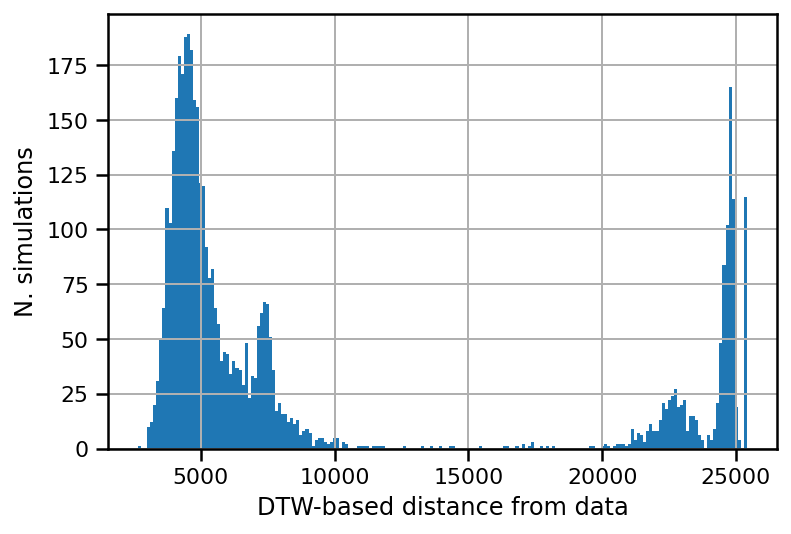

In [79]:
dtwd_list.hist(bins=200)
plt.xlabel('DTW-based distance from data')
plt.ylabel('N. simulations');

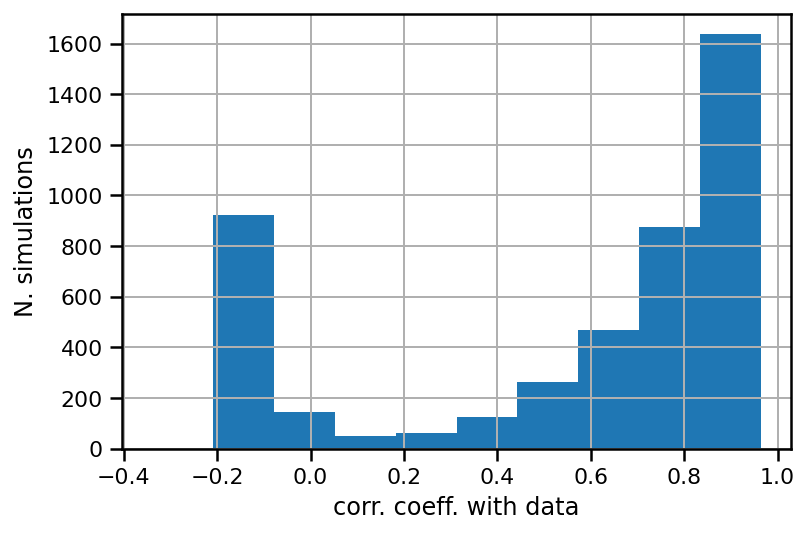

In [80]:
corrd_list.hist()
plt.xlabel('corr. coeff. with data')
plt.ylabel('N. simulations');

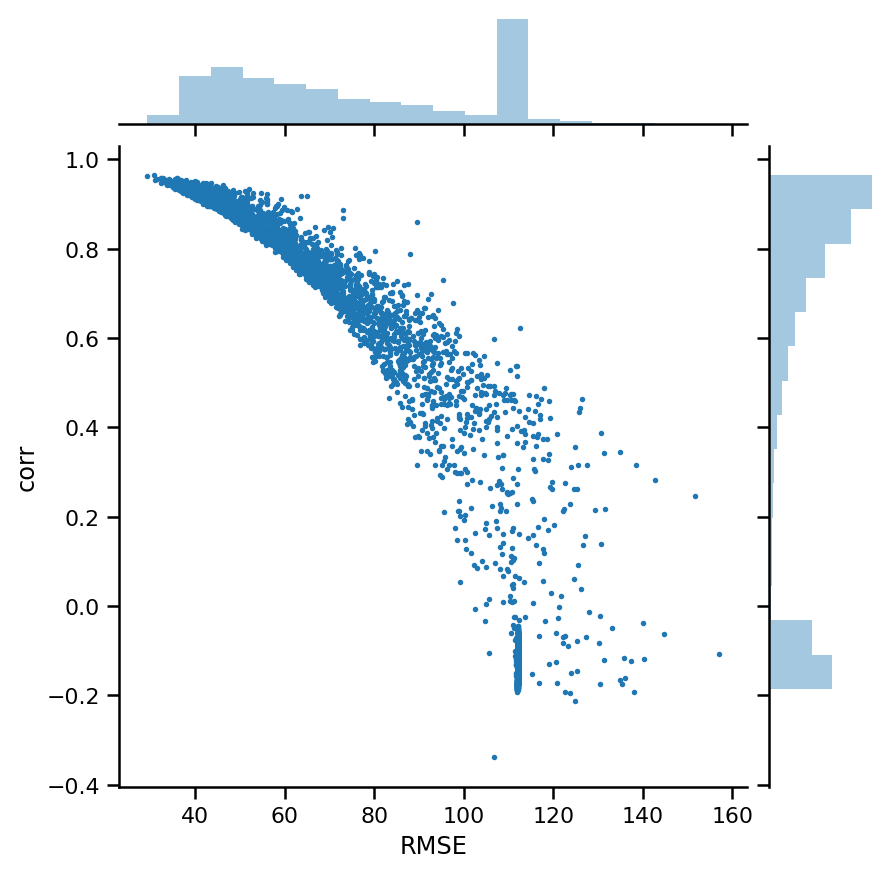

In [81]:
sns.jointplot(rmse_list,corrd_list,s=3)\
.set_axis_labels("RMSE", "corr");

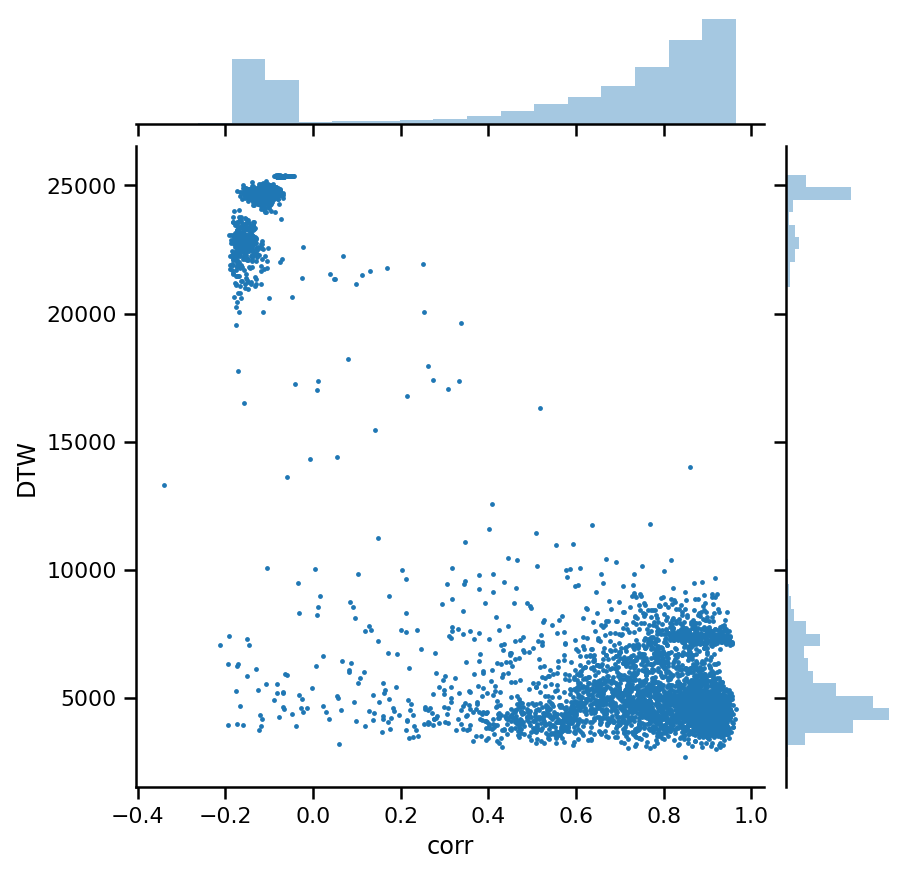

In [82]:
# insteresting PLOT?
sns.jointplot(corrd_list,dtwd_list,s=2)\
.set_axis_labels("corr",'DTW');

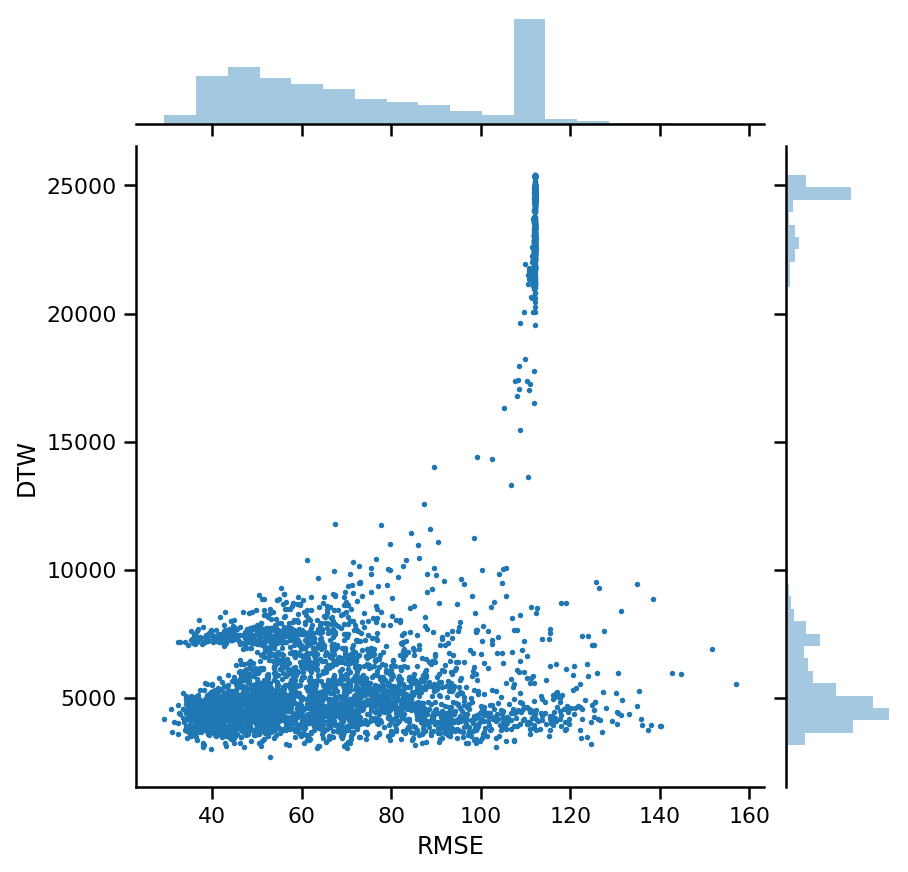

In [83]:
sns.jointplot(rmse_list,dtwd_list,s=3)\
.set_axis_labels("RMSE", "DTW");

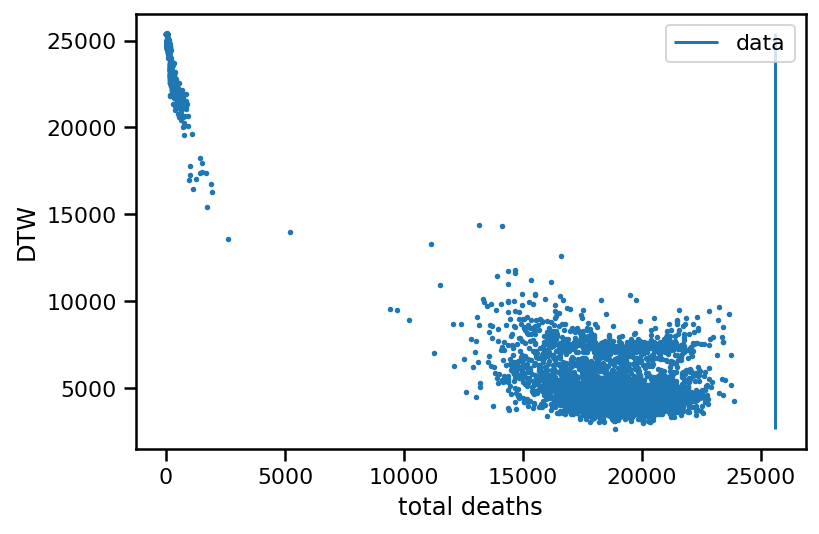

In [84]:
plt.scatter(removed_inc.sum(), dtwd_list, s=3)
plt.xlabel("total deaths")
# plt.ylabel("RMSE")
plt.ylabel("DTW")

# plt.ylim([2e3,7e3])
plt.vlines(x=data_to_fit.sum(), 
           ymin=dtwd_list.min(),
           ymax=dtwd_list.max(),
           label='data')
plt.legend();

In [85]:
# show different behaviour of the metrics -- non-correlated points
dtw_threshold = 7000
rmse_threshold = 140

In [86]:
dtwd_list[(dtwd_list < dtw_threshold) & \
          (rmse_list > rmse_threshold)]

7       3896.0
127     3882.0
2696    5916.0
3472    6888.0
3592    5538.0
4428    5975.0
dtype: float64

In [87]:
rmse_list[(dtwd_list < dtw_threshold) & \
          (rmse_list > rmse_threshold)]

7       140.213846
127     140.029693
2696    144.750432
3472    151.704161
3592    156.932000
4428    142.704967
dtype: float64

identify 'remarkable' runs

In [88]:
## run with highest incidence at midterm
# highest_late = removed_inc.iloc[:,int(removed_inc.shape[1]/2)].idxmax()

## longest run defined as the one with lower amount of 0 removed
longest_sim_1 = removed_inc.apply(lambda x: sum(x == 0)).idxmin()
print('longest run: ', longest_sim_1)

# sim with highest incidence
print('sim with highest incidence: ', removed_inc.max().idxmax())

longest run:  1352
sim with highest incidence:  4428


## (static) plot

(this plot is not in the paper)

In [89]:
# simply list runs with 'low' DTW distance
dtwd_list[dtwd_list < 3000]

534    2658.0
dtype: float64

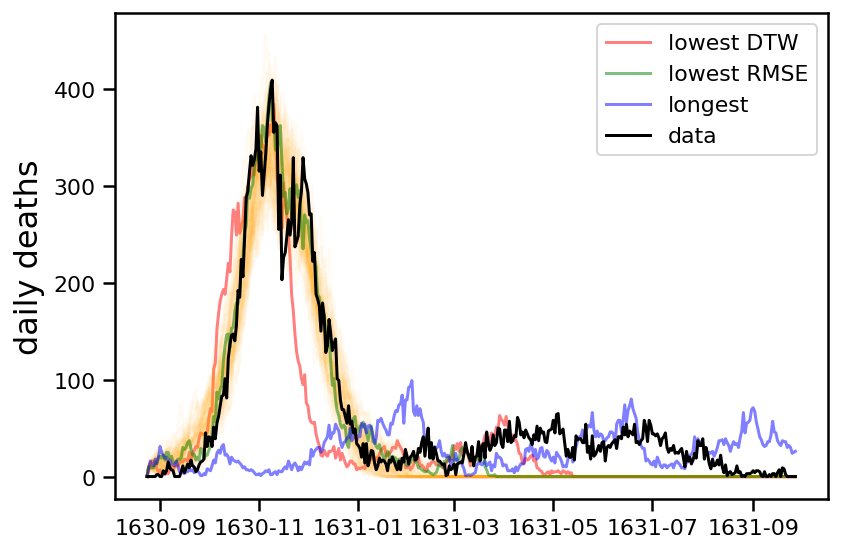

In [91]:
# plt.figure(figsize=(12, 5))

###  we plot only runs with given 'goodness of fit' ### ###  
# dtwd_filtered = dtwd_list[dtwd_list < 3000]
# plt.plot(data_to_fit.index,removed_inc[dtwd_filtered.index],
#          alpha=0.2, c='orange')
plt.plot(data_to_fit.index,removed_inc[dtwd_list.idxmin()],
         alpha=0.5, c='red', label='lowest DTW')


rmse_filtered = rmse_list[rmse_list < 35]
plt.plot(data_to_fit.index,removed_inc[rmse_filtered.index],
         alpha=0.05, c='orange')
plt.plot(data_to_fit.index,removed_inc[rmse_list.idxmin()],
         alpha=0.5, c='green', label='lowest RMSE')
### ###  ### ###  ### ###  ### ###  ### ###  ### ###  ### ### 

### ###  ### ### ## other specific runs ### ###  ### ###
plt.plot(data_to_fit.index,removed_inc[longest_sim_1],
         alpha=0.5, c='blue', label='longest')


# runs_to_plot = dtwd_list[(dtwd_list < dtw_threshold) & (rmse_list > rmse_threshold)].index
# for run in runs_to_plot:
#     plt.plot(data_to_fit.index,removed_inc[run],
#              alpha=0.5, label='ID:{}'.format(run))
### ###  ### ###### ###  ### ###### ###  ### ###### ###  ### ###### ###  ### ###

plt.ylabel('daily deaths',size=16)

## remind that this section is not meant for fitting
## --> get data from epid_simulations.ipynb#prepare-data-for-fit
plt.plot(data_to_fit.index,data_to_fit.values, label='data',c='black')

plt.legend()
plt.tight_layout();

# plt.savefig('./simulations_plots/stoch_sim_ER_best_rmse_dtw_longest.pdf');

this is fig. __SI6a__ of the paper

In [15]:
rmse_list =  grouped_remov_inc.apply(lambda y: np.sqrt(mean_squared_error(y,data_to_fit)))

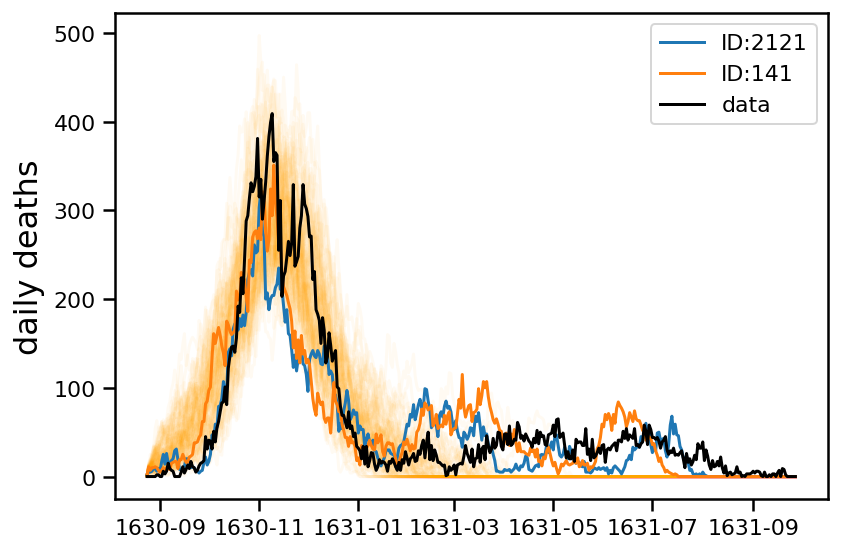

In [16]:
# plt.figure(figsize=(12, 5))

# grouped_remov_inc.plot(label=removed_inc.index)

### ###  we plot only runs with given 'goodness of fit'
# dtwd_filtered = dtwd_list[dtwd_list < 5000]
# plt.plot(grouped_remov_inc.iloc[:,dtwd_filtered.index],
#          alpha=0.2, c='orange')
# plt.plot(grouped_remov_inc.iloc[:, dtwd_list.idxmin()],
#          alpha=0.5, c='green', label='DTW best-fit')


rmse_filtered = rmse_list[rmse_list < 50]
plt.plot(data_to_fit.index,grouped_remov_inc.iloc[:,rmse_filtered.index],
         alpha=0.05, c='orange')
# plt.plot(grouped_remov_inc.iloc[:, rmse_list.idxmin()],
#          alpha=0.5, c='green', label='RMSE best-fit')

# corrd_filtered = corrd_list[corrd_list > 0.9]
# plt.plot(grouped_remov_inc.iloc[:,corrd_filtered.index],
#          alpha=0.1, c='orange')
# plt.plot(grouped_remov_inc.iloc[:, corrd_list.idxmax()],
#          alpha=0.5, c='green', label='CORR best-fit')


### ### ### 

## other specific runs
# plt.plot(grouped_remov_inc.iloc[:, longest_sim_1],
#          alpha=0.5, c='blue', label='longest')

runs_to_plot = [2121,141] # 372,1375

for run in runs_to_plot:
    
    plt.plot(data_to_fit.index,grouped_remov_inc.iloc[:, run],
             alpha=1, label='ID:{}'.format(run))

plt.ylabel('daily deaths',size=16)


## --> get data from epid_simulations.ipynb#prepare-data-for-fit
plt.plot(data_to_fit.index,data_to_fit.values, label='data',c='black')

plt.legend()
plt.tight_layout()


# plt.savefig('diff_evol_fixed_topo_pars_2ts_{}_{}_{}_all_runs_v4.pdf'.format(*[np.round(p,6) for p in results]))
plt.savefig('./simulations_plots/stoch_sim_for_paper_pars_2ts_best_rmse.pdf')

# plt.savefig(
#     'explor_trial_WS_2ts_N_{}_beta_{}_gamma_{}_initinf_{}_v2.pdf'.format(
#         n_nodes,
#         model.get_info()['beta'],

#         model.get_info()['gamma'],
#         model.get_info()['fraction_infected']))

## __interactive__ plot 

code for interactive version of previous plots

In [95]:
import plotly.offline as py
import cufflinks as cf
cf.set_config_file(offline=True, theme='white')

In [21]:
results = [4.87669804e-01, 8.29038768e-01, 2.06927577e-05]

In [96]:
results = [0.238153,0.852766,8.1e-05]

In [98]:
dtwd_filtered = dtwd_list[dtwd_list < 3000]

In [99]:
# df_for_plotly = grouped_remov_inc.copy()

# df_for_plotly = grouped_remov_inc.iloc[:,dtwd_filtered.index].copy()
# df_for_plotly = grouped_remov_inc.iloc[:,rmse_filtered.index].copy()
# df_for_plotly = grouped_remov_inc.iloc[:, corrd_filtered.index].copy()

df_for_plotly = removed_inc.iloc[:,dtwd_filtered.index].copy()

# add data column
df_for_plotly['data'] = data_to_fit.values

# df_for_plotly.iplot()
df_for_plotly.iplot(asPlot=True,filename='./simulations_plots/diff_evol_ER_{}_{}_{}_N_runs_{}'.format(*[np.round(p, 6) for p in results], 
                                                                                                      removed_inc.shape[1]))

#     asPlot=True,filename='./simulations_plots/diff_evol_fixed_topo_pars_2ts_{}_{}_{}_N_runs_{}'.format(*[np.round(p, 6) for p in results], grouped_remov_inc.shape[1]))
# asPlot=True,filename='diff_evol_fixed_topo_pars_2ts_{}_{}_{}_all_runs'.format(*[np.round(p, 6) for p in results]))

'./simulations_plots/diff_evol_ER_0.238153_0.852766_8.1e-05_N_runs_4545.html'

# parameters estimation

## model and error functions

build the network (WS or ER)

In [4]:
### ### ### ### ###  WS graph ### ### ### ### ###
# cell to be used in case of simulation with fixed topology 
# (which is in the end what we do for the paper)
# (no need to build the network every time)


n_nodes = 1400000
nnn = 5
topol_par = 0.04
# topol_par = 0.01
# topol_par = 0.04643226

g = nx.watts_strogatz_graph(n_nodes, nnn, topol_par)

In [ ]:
### ### ### ### ###  ER graph ### ### ### ### ###
pn_best = 3.2715945648564846
n_nodes = 5500

print('generate ER graph with p:', pn_best / n_nodes)
%time g = nx.erdos_renyi_graph(n_nodes,pn_best/n_nodes)

# extract giant component
giant = max(nx.connected_component_subgraphs(g), key=len)

define fun. for stochastic simulations

In [18]:
def stochas_sim(beta,
                gamma,
                init_inf,
                single_run=False,
                exe_n=3 * 8,
                n_procs=8,
                n_iter=800):

    ### ### ### in case you want to fit also the topology parameter ### ### ### 
    # def stochas_sim(topol_par, beta, gamma, init_inf, single_run=False):
    # def stochas_sim(topol_par, beta, gamma, init_inf=0.001, single_run=False):
    ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### 
    
    '''
    Function to run epidemic simulation on graph
    
    (topol_par: parameter tuning the graph topology - basically the rewiring probability in the W-S model)
    
    beta: infection rate
    gamma: recovery rate
    init_inf: fraction of initial infected
    
    single_run: boolean -- whether to run single or multiple ones
    
    we expose the same parameters of multi_runs from ndlib.utils sub-module:
    exe_n: number of instantiations
    n_procs: number of processes. Default values cpu number.
    n_iter: number of iteration ~ epidemic length  in timesteps
    '''

    ### ### ### in case you want to fit also the topology parameter ### ### ###     
    # build graph
    #     g = nx.watts_strogatz_graph(n_nodes, nnn, topol_par)

    #     my_comm = nx.community.greedy_modularity_communities(g)
    #     print('N. communities', len(my_comm))
    #     print('modularity', nx.community.modularity(g, my_comm))
    ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### 
    
    # configure the model
    cfg = mc.Configuration()

    cfg.add_model_parameter('beta', beta)  # infection rate
    cfg.add_model_parameter('gamma', gamma)  # recovery rate

    cfg.add_model_parameter('fraction_infected', init_inf)  
    cfg.add_model_parameter('tp_rate', 1)  # 0:mean-field VS 1:full stoch.

    # re-setting the model
    model = epidemics.SIRModel(g)  ##
    #     model = epidemics.SIRModel(giant) ##
    model.set_initial_status(cfg)
    #     print(model.get_info())

    ## run epidemic simulations
    if single_run:

        ##  SINGLE run the SIR simulations
        iterations = model.iteration_bunch(n_iter, node_status=True)
        trends = model.build_trends(iterations)

        ## v. witn no aggregation
        #return trends[0]['trends']['status_delta'][2]

        ## 2-timestep aggregation!
        removed_inc = pd.Series(trends[0]['trends']['status_delta'][2])
        grouped_df = removed_inc.groupby(removed_inc.index // 2).sum()
        return grouped_df

    else:
        ## run MULTIPLE simulation, for each parameter combination
        trends = multi_runs(model,
                            execution_number=exe_n,
                            iteration_number=n_iter,
                            nprocesses=n_procs)

        # extract data from sim module
        removed_inc = pd.DataFrame([t['trends']['status_delta'][2] for t in trends])

        ## v. witn no aggregation
        #return removed_inc.transpose()

        ## 2-timestep aggregation!
        removed_inc_t = removed_inc.transpose()
        grouped_df = removed_inc_t.groupby(removed_inc_t.index // 2).sum()

        return grouped_df

define error function to minimize

In [19]:
from sklearn.metrics import mean_squared_error

def err_fun(pars):
    '''
    Return RMSE between data and (mean/median) prediction 
    
    pars: see 'stochas_sim' function - (topology and/or) epid. model rates
    '''

    grouped_remov_inc = stochas_sim(*pars)
    return np.mean(grouped_remov_inc.apply(lambda y: np.sqrt(mean_squared_error(data_to_fit, y))))

    ### v. for single_run
    #     sim_pred = stochas_sim(*pars,single_run=True)
    #     return np.sqrt(mean_squared_error(data_to_fit,sim_pred))

## `differential_evolution` 

as it's usually too slow on a laptop, we run it on the ICC cluster 

In [20]:
## ## ## this is in case, the function used for fitting ## ## ## 
# from scipy.optimize import differential_evolution

### nested parallelization

in order to run 'nested' multiprocess, we need to create non-daemonic processes... -- see [this SO post](https://stackoverflow.com/questions/6974695/python-process-pool-non-daemonic)

In [ ]:
import multiprocessing

class NoDaemonProcess(multiprocessing.Process):
    @property
    def daemon(self):
        return False

    @daemon.setter
    def daemon(self, value):
        pass


class NoDaemonContext(type(multiprocessing.get_context())):
    Process = NoDaemonProcess

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(multiprocessing.pool.Pool):
    def __init__(self, *args, **kwargs):
        kwargs['context'] = NoDaemonContext()
        super(MyPool, self).__init__(*args, **kwargs)

actual run of the global optim.

In [ ]:
my_pool = MyPool(3)

%time best_fit = differential_evolution(err_fun, bounds=[(0.01, 0.5),(0.01,0.5),(1e-3,1e-2)],\
                                        workers=my_pool.map,polish=False,maxiter=5,tol=10)

# shut down the pool when it's done
my_pool.terminate() 


# (0.5, 2),(0.5, 2) ## beta,gamma - bounds
# args=(best_rew_pro,0.001)
# , (0.01, 0.1), (0.0001, 0.001)])

best_fit

###  external parallelization only

In [11]:
nfeval = 1


def cb_fun(par, convergence=1):
    '''
    callback fun to get intermetiate results
    '''
    global nfeval
    print('nfeval:', nfeval, 'parameters:', par)
    nfeval += 1

    if convergence > 1:
        return True

In [ ]:
%time best_fit = differential_evolution(err_fun, bounds=[(0.01,1),(0.01,1),(1e-5,1e-3)],\
                                        disp=True,callback=cb_fun,tol=10,\
                                        workers=7,polish=False)
#recombination=1,\
best_fit

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:461: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


## plot data with fitted model

overview of the network used for the simulation

In [6]:
## nodes and degree
print('N nodes:', g.number_of_nodes(), 'N edges:', g.number_of_edges())
degrees = list(dict(g.degree()).values())
print('mean degree:', np.round(np.mean(degrees), 3))

plt.bar(range(0, len(nx.degree_histogram(g)), 1), nx.degree_histogram(g))
plt.xlabel('node degree')
plt.ylabel('N. nodes')

## conn. comp. ananlysis
print('N. cc:', nx.number_connected_components(g))

S = [g.subgraph(c).copy() for c in nx.connected_components(g)] # this takes few sec more...
giant = max(S, key=len)
print('largest cc size fraction:',
      np.round(giant.number_of_nodes() / g.number_of_nodes(), 3))

N nodes: 1400000 N edges: 2800000
mean degree: 4.0
N. cc: 1
largest cc size fraction: 1.0


don't run community analysis on very large (>10k) graphs (too slow)

In [ ]:
## community analysis
my_comm = nx.community.greedy_modularity_communities(giant)
print('N. communities giant comp.', len(my_comm))
print('modularity giant comp.', np.round(nx.community.modularity(giant, my_comm),2))

check $ \beta, \gamma, R_{0}$

re-compute prediction and error using best fit result -- here best fit values are taken from simulations on the ICC

In [10]:
 ###### ###### WS graph ###### ######

## latest best fit results from ./venice_sim_ICC/diff_evol_results_fixed_topology_tol_1e-1.txt 
# %time med_pred, first_q_pred, third_q_pred = stochas_sim(*[0.02269908, 0.0268182 , 0.00666378])
# %time mean_pred, first_q_pred, third_q_pred = stochas_sim(*[0.08676415, 0.0756848 , 0.00203205])

## this is another trial to test relation between old and new implementation
# %time med_pred, first_q_pred, third_q_pred = stochas_sim(*[0.06362098/np.mean(degrees), 0.05553447, 0.0234674]) 

## latest best fit results from ./venice_sim_ICC/diff_evol_results_fixed_topology_tol_5_1e-2.txt 
# %time mean_pred, first_q_pred, third_q_pred = stochas_sim(*[0.03376511, 0.03253843, 0.00568103],exe_n=20*8) 

## latest best fit results from ./venice_sim_ICC/diff_evol_results_fixed_topology_tol_1e-2.txt -- BEST SO FAR
# %time mean_pred, first_q_pred, third_q_pred = stochas_sim(*[0.04458944, 0.03719893, 0.00425658],return_data='mean') 
# %time mean_pred, first_q_pred, third_q_pred = stochas_sim(*[0.04458944, 0.03719893, 0.00425658],return_data='mean') 
# %time removed_inc = stochas_sim(*[0.04458944, 0.03719893, 0.00425658],return_data='all') 
# %time med_pred, first_q_pred, third_q_pred = stochas_sim(*[0.04458944, 0.03719893, 0.00425658]) 


## best fit results from diff_evol run on laptop -- see prev. section (fixed topology)
# %time med_pred, first_q_pred, third_q_pred = stochas_sim(*best_fit.x)
# %time mean_pred, first_q_pred, third_q_pred = stochas_sim(*best_fit.x,return_data='mean')

## latest best fit results from ./venice_sim_ICC/diff_evol_results_fixed_topology_tol_1e-1_rec_1.txt
# %time mean_pred, first_q_pred, third_q_pred = stochas_sim(*results,return_data='mean') 

In [11]:
###### ###### ER graph ###### ######

# best fir on ER graph from ./venice_sim_ICC/diff_evol_results_ER_fixed_topology_tol_5_1e-2.txt
# best fir on ER graph from ./venice_sim_ICC/diff_evol_results_ER_fixed_topology_tol_1e-2.txt
# best fir on ER graph from ./venice_sim_ICC/diff_evol_results_ER_giant_fixed_topology_tol_5e-2.txt
# results = [0.02794348, 0.05902934, 0.00873069]

# # best fir on ER graph from ./venice_sim_ICC/diff_evol_results_ER_giant_fixed_topology_tol_3e-2.txt
# results = [0.02238083, 0.04644033, 0.00608499]

# best fir on ER graph from ./venice_sim_ICC/diff_evol_results_ER_giant_fixed_topology_tol_1e-2.txt
# results = [0.02712342, 0.05849008, 0.00605656]
# results = [0.03787077, 0.08334758, 0.00191569]


# %time mean_pred, first_q_pred, third_q_pred = stochas_sim(*results,return_data='mean') 

In [12]:

# print('total data:',data_to_fit.sum(),'total pred:',np.round(mean_pred.sum(),3))

# np.sqrt(mean_squared_error(mean_pred, data_to_fit))
# np.sqrt(mean_squared_error(med_pred, data_to_fit))

@city level! – mind that also this cell was run on the cluster (note N cpus used : 45)

In [8]:
# results = [5.31261136e-01, 4.84263628e+00, 3.31151161e-04]

## from ./venice_sim_ICC/fit_at_city_level/diff_evol_results_fixed_topology_tol_2_1e-2.txt
# results = [4.71818600e-01, 7.57240146e-01, 8.73582950e-05]

## from venice_sim_ICC/fit_at_city_level/diff_evol_results_fixed_topology_tol_5_1e-2_polished.txt
# results = [4.97024567e-01, 8.54549412e-01, 9.80649558e-05]

## results with 2 \delta-t -- tol=0.05
results = [4.87669804e-01, 8.29038768e-01, 2.06927577e-05]

%time removed_inc = stochas_sim(*results,exe_n=180,n_procs=45)

In [9]:
from scipy.stats import variation

# 'R0'
beta  = results[0] # best_fit.x[0]
gamma = results[1] # best_fit.x[1] 

giant_degrees = list(dict(giant.degree()).values())

# from scipy.stats import variation
R0_eff = beta / gamma * np.mean(giant_degrees) * (1 + variation(giant_degrees)**2)
print('R0_eff:',np.round(R0_eff,4))

R0_eff: 2.376


here are some single trial

In [ ]:
## 'hand-made' trial
# %time mean_pred, first_q_pred, third_q_pred = stochas_sim(*[0.01, 0.03, 0.02, 0.01])
%time mean_pred, first_q_pred, third_q_pred = stochas_sim(*[0.03, 0.02, 0.01],return_mean=True)

print(data_to_fit.sum(),mean_pred.sum())

np.sqrt(mean_squared_error(mean_pred, data_to_fit))

compute deviations from data -- to be laoded from _section below_!!

In [15]:
from sklearn.metrics import mean_squared_error

rmse_list =  removed_inc.apply(lambda y: np.sqrt(mean_squared_error(y,data_to_fit)))
print('best run -- lowest rmse',rmse_list.idxmin(),rmse_list.min())

best run -- lowest rmse 1 62.071088277877


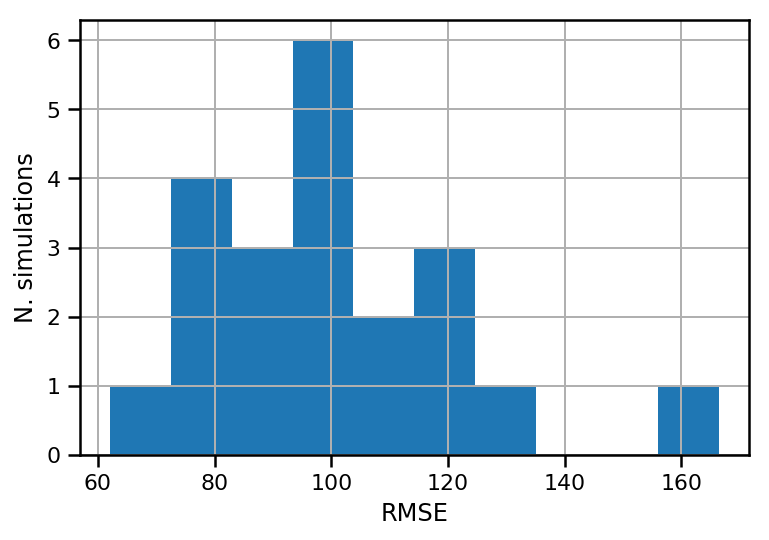

In [16]:
rmse_list.hist()

plt.xlabel('RMSE')
plt.ylabel('N. simulations');

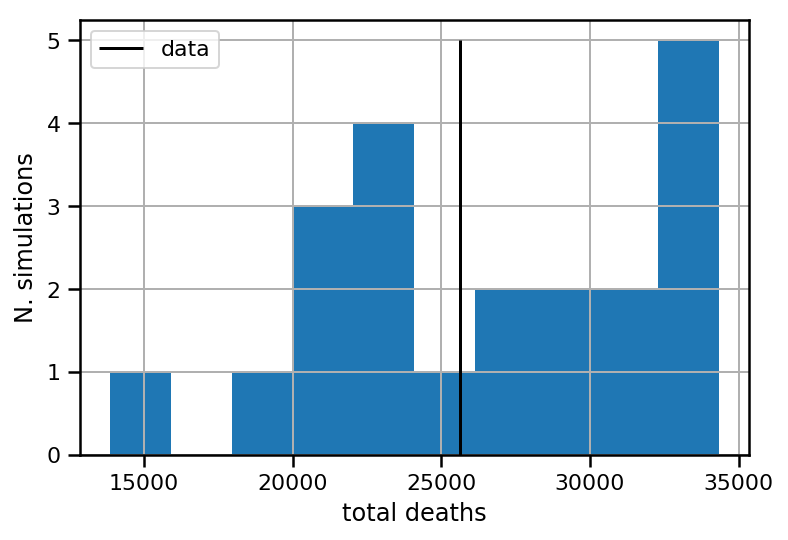

In [17]:
removed_inc.apply(lambda y: sum(y)).hist()
plt.vlines(x=data_to_fit.sum(),ymin=0,ymax=5,label='data')
plt.legend()
plt.xlabel('total deaths')
plt.ylabel('N. simulations');

identify 'remarkable' runs

In [18]:
## run with highest incidence at midterm 
# highest_late = removed_inc.iloc[:,int(removed_inc.shape[1]/2)].idxmax()

## longest run defined as the one with lower amount of 0 removed
longest_sim_1 = removed_inc.apply(lambda x: sum(x==0)).idxmin()

final plot

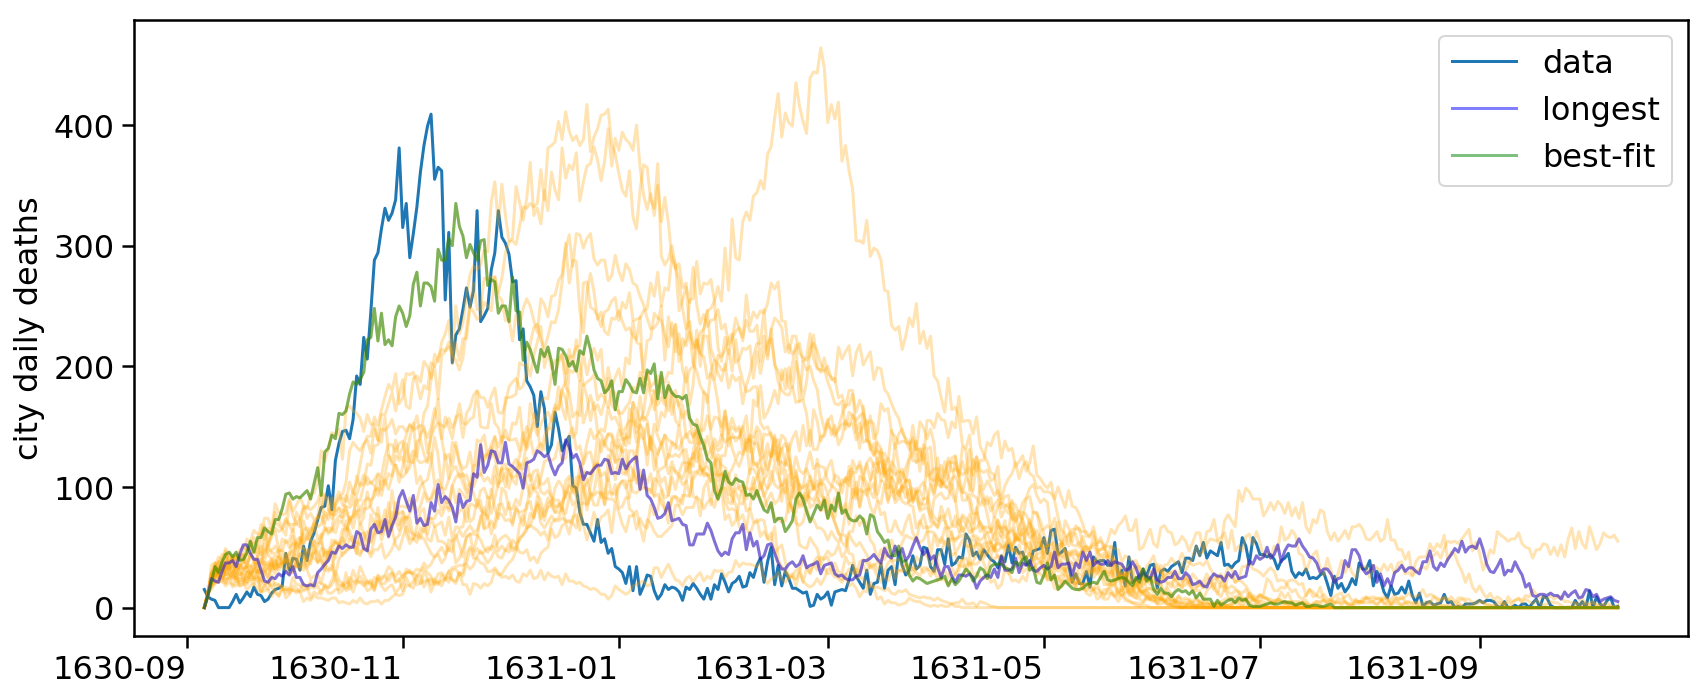

In [34]:
plt.figure(figsize=(12, 5))

## plot original data
# plt.locator_params(axis='x', tight=True)
# plt.plot(new_df.counts[new_df.is_plague == True][10:310], label='plague')
# plt.plot(new_df.counts[new_df.is_plague == False][10:310], label='non-plague')

## plot fitted data
data_to_fit.plot(label='data', alpha=1)  #, marker='.', linestyle='')


## simlations, in case of multiple runs
# plt.plot(data_to_fit.index,med_pred,label='median\nstoch. sim.',alpha=0.5)
# plt.plot(data_to_fit.index,mean_pred,label='mean\nstoch. sim.',alpha=0.5)
# plt.fill_between(data_to_fit.index,first_q_pred,third_q_pred,
#                  alpha=0.2,color='orange')

plt.plot(data_to_fit.index,removed_inc,alpha=0.3,color='orange')

plt.plot(data_to_fit.index,removed_inc.iloc[:, longest_sim_1], alpha=0.5, c='blue', label='longest')
plt.plot(data_to_fit.index,removed_inc.iloc[:, rmse_list.idxmin()], alpha=0.5, c='green', label='best-fit')

plt.legend()

# plt.ylabel('S. Eufemia\ndaily deaths', size=16)
plt.ylabel('city daily deaths', size=16)
plt.legend(prop={'size': 16})

plt.xticks(rotation=0)
plt.xticks(size=16)
plt.yticks(size=16)

plt.tight_layout()

# plt.savefig('simulations_plots/diff_evol_ER_giant_fixed_topo_pars_{}_{}_{}.pdf'.format(*[p for p in results]))
# plt.savefig('simulations_plots/diff_evol_ER_fixed_topo_pars_{}_{}_{}.pdf'.format(*[p for p in results]))

plt.savefig('simulations_plots/diff_evol_fixed_topo_pars_{}_{}_{}_all_runs.pdf'.format(*[p for p in results]))

interactive version of the previous plots

In [27]:
import plotly.offline as py
import cufflinks as cf
cf.set_config_file(offline=True,theme='white')

In [ ]:
df_for_plotly = removed_inc.copy()
df_for_plotly['data'] = data_to_fit.values

df_for_plotly.iplot()
#     asPlot=True,
#     filename='diff_evol_fixed_topo_pars_{}_{}_{}_all_runs'.format(
#         *[np.round(p, 6) for p in results]))

# behavioral $\beta$  v. 

## define and test model  

define $\beta$ dependence from infected

In [3]:
# def behav_beta(infected, beta0, beta1, char_inf_n):
def behav_beta(infected, beta0, char_inf_n):
    '''
    return exp decreasing  beta function
    
    * beta0 : beta scale factor
    * char_inf_n: slope factor (characteristic N infectious)
    '''

    return beta0 * np.exp(-infected / char_inf_n) #+ beta1

In [5]:
### just for records: we choose the exp v.  ### 

def behav_beta(infected, beta0, char_inf_n):
    '''
    returns decreasing step function, 
    at infected <= char_inf_n:
    
    * beta0: value before transition
    * beta1: value after transition    
    * char_inf_n: transition point (characteristic N infectious)
    '''

    if infected <= char_inf_n:
        return beta0
    else:
        return beta1

set model parameters (from previous fit)

In [4]:
### parameters for v. with exp decaying beta(I) ### 

N_est = 140000 # estim. N. ppl at the time, in Venice

## results from different fitting experiments
#fit_results = [2.51481626e-01, 4.39243555e+01, 4.93404719e+01, 5.07236014e-02,1.10819757e-05] #fit on WS
# fit_results = [2.03320049e-01, 4.43220415e+01, 1.87640138e+01, 6.87381010e-02, 9.44991349e-06] #fit on ER, tol=1
# fit_results = [7.41939025e-02, 5.10888249e+01, 4.35903279e+01, 2.46341540e-02, 5.80375387e-05] #fit on ER, tol=0.5
fit_results = [6.00429117e-02, 7.21474524e+01, 3.25677766e+01, 2.85897098e-02, 1.71654844e-04] #fit on ER, tol=0.1, NORM incidence!
# fit_results = [5.36195528e-02, 6.04699110e+01, 3.82548009e+01, 3.34199330e-02, 4.60800283e-04] #fit on ER, tol=0.01, NORM incidence!


# test_values = [0.04, 120, 30, 0.03, 4e-4]

 ### ### ###  ### ### ###  ### ### ###  ### ### ###  ### ### ###  ### ### ### 

test_beta0 = fit_results[0] ## also used for beh. beta
test_slope = fit_results[1]
test_tau = fit_results[2]
test_gamma = fit_results[3]
fraction_infected = fit_results[4]

print('initial R0:',test_beta0 / test_gamma)

initial R0: 2.100158138016497


In [6]:
### parameters for v. with step beta(I) ### 

# fit_results = [0.04, 0.001, 70, 30, 0.03, 4e-4]
fit_results = [4.03117107e-02, 4.51671617e-03, 5.73822912e+01, 4.04873265e+01, 4.23712026e-02, 4.45048277e-04]

N_est = 140000 # estim. N. ppl at the time, in Venice

## ## these are passed to beta fun
test_beta0 = fit_results[0]  
test_beta1 = fit_results[1] 
test_transition = fit_results[2] 
test_tau = fit_results[3]
## ## ## 

test_gamma = fit_results[4]
fraction_infected = fit_results[5]

print('initial R0:',test_beta0 / test_gamma)

### ### ###  ### ### ###  ### ### ###  ### ### 

initial R0: 0.9513940654589776


build graph and set the model 

In [5]:
n_nodes = 20000 
prob_edge = 4 / n_nodes  # 3.27/ n_nodes
print(prob_edge * n_nodes)

%time g = nx.fast_gnp_random_graph(n_nodes, prob_edge)

4.0
CPU times: user 144 ms, sys: 6.97 ms, total: 151 ms
Wall time: 150 ms


In [6]:
# set graph into model
giant = g.subgraph(sorted(nx.connected_components(g),key=len,reverse=True)[0])
model = epidemics.SIRModel(giant)      
print('N nodes in gcc', giant.number_of_nodes())

# set initial parameters
cfg = mc.Configuration()
cfg.add_model_parameter('beta', test_beta0)
cfg.add_model_parameter('gamma', test_gamma)
cfg.add_model_parameter('fraction_infected', fraction_infected) #1.1 / g.number_of_nodes()

# double check
model.set_initial_status(cfg)
model.get_info()

N nodes in gcc 19590


{'beta': 0.0600429117,
 'gamma': 0.0285897098,
 'fraction_infected': 0.000171654844,
 'tp_rate': 1}

run simulations (quite slow to re-run on whole (N=140k) graph -- > you can simply **reload saved results** below)

In [ ]:
%%time

n_tot_iteration = 400

# initialize iterations list
iterations = []

### ### DEBUG: check beta ### ###
storing_step = test_slope // 2
# storing_step = test_transition // 2

beta_logs = []
inf_logs = []
beta_logs.append(test_beta0)

### ### ### ### ### ### ### ###

for i in range(n_tot_iteration):

    iterations.append(model.iteration())

    if (i + 1) >= test_tau:  # mind that: len(iteration)= i+1

        # get N. infected at time t-tau
        delayed_N_inf = iterations[-int(test_tau)]['node_count'][1]

        # re-compute beta
        beta = behav_beta(delayed_N_inf, test_beta0,
                          test_slope)  ## for exp. dec. fun.
        #         beta = behav_beta(delayed_N_inf, test_beta0, test_beta1, test_transition) ## for step fun.
        model.params['model']['beta'] = beta

        if (i + 1) % storing_step == 0:
            inf_logs.append(delayed_N_inf)
            beta_logs.append(beta)

# need to first convert iterations to 'trends' for plotting
trends = model.build_trends(iterations)

assessing GOD (goodness of fit)

In [111]:
print('RMSE:', np.sqrt(mean_squared_error(data_to_fit / N_est,
                                         np.array(trends[0]['trends']['status_delta'][2]) / model.graph.number_of_nodes())))

print('R2 score:', r2_score(data_to_fit / N_est,
                            np.array(trends[0]['trends']['status_delta'][2]) / model.graph.number_of_nodes()))

RMSE: 0.0002588912805369397
R2 score: 0.8444302303560551


save large simulations results (in order to be able to plot without re running)

In [117]:
pd.Series(trends[0]['trends']['status_delta'][2]).to_csv(
    './simulations_plots/delayed_behav_sir_stoch/good_single_run_removed.csv')

pd.Series(beta_logs).to_csv(
    'simulations_plots/delayed_behav_sir_stoch/good_single_run_beta_logs.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  from ipykernel import kernelapp as app


**re-load** results

In [7]:
trends_to_plot = pd.read_csv(
    'simulations_plots/delayed_behav_sir_stoch/good_single_run_removed.csv',
    usecols=[1],
    header=None)

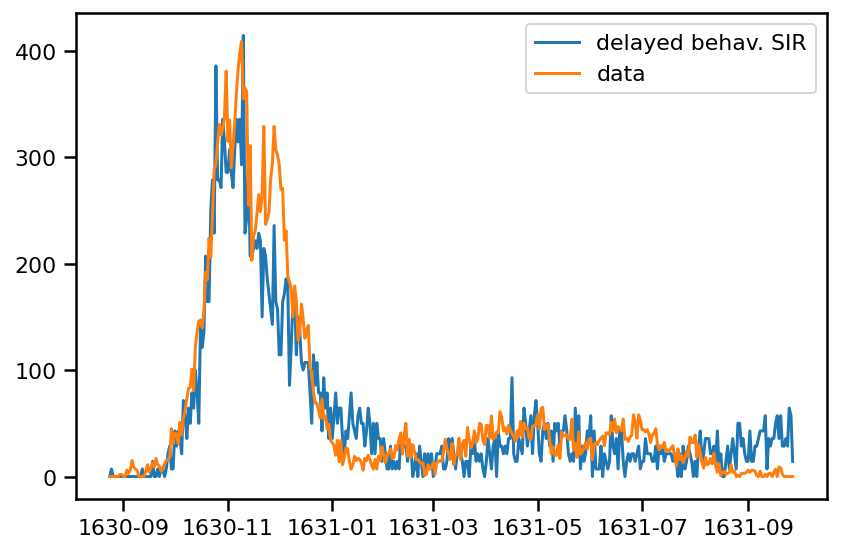

In [10]:
plt.plot(data_to_fit.index,
         trends_to_plot / model.graph.number_of_nodes() * N_est,
         label='delayed behav. SIR')

plt.plot(data_to_fit, label='data')

plt.legend()
plt.tight_layout()

analize the epidemics (if you run the simulations)

In [ ]:
# plt.plot(trends[0]['trends']['node_count'][1],
#         label='infected')

plt.plot(data_to_fit.index,
         np.array(trends[0]['trends']['status_delta'][2]) / model.graph.number_of_nodes() * N_est,
         label='delayed behav. SIR')

plt.plot(data_to_fit, label='data')

plt.legend()

# plt.ylabel('daily removed')

#plt.ylim([-5,450])
plt.tight_layout()

# build plot filename to save
my_comment1 = 'ICC_ER_fit_' # 'ICC_ER_fit_step_fun_', 'trial_ER_' #'ICC_fit_' # 'ICC_WS_fit_' ,  ICC_ER_fit_zoomed_
my_file_name = my_comment1 + 'beta0_{}_slope_{}_tau_{}_gamma_{}_N_nodes_{}'.\
                 format(test_beta0,test_slope,test_tau,test_gamma,model.graph.number_of_nodes())
# plt.savefig('simulations_plots/delayed_behav_sir_stoch/' + my_file_name + '.pdf')

### ### ### 
# my_file_name = my_comment1 + 'beta0_{}_beta1_{}_transit_{}_tau_{}_gamma_{}_N_nodes_{}'.\
#                  format(test_beta0,test_beta1,test_transition,test_tau,test_gamma,model.graph.number_of_nodes())

reload betaS

In [69]:
beta_logs = pd.read_csv('./simulations_plots/delayed_behav_sir_stoch/good_single_run_beta_logs.csv',header=None,index_col=0)
beta_logs = beta_logs.values.flatten().tolist()

In [85]:
plt.plot(data_to_fit.index[::36], beta_logs, label='beta')  # r'$\beta$'
plt.hlines(test_gamma,
           data_to_fit.index[0],
           data_to_fit.index[-1],
           label='gamma',
           color='#ff7f0e')  #r'$\gamma$'
plt.plot(data_to_fit.index[::36],
         [b / test_gamma for b in beta_logs],
         label='beta / gamma',
         c='g')  # r'$\beta / \gamma$',

plt.legend()
# plt.show()

### build plot filename to save
# my_comment2 = 'epid_pars_over_time_'

# my_file_name = my_comment2 + 'beta0_{}_slope_{}_tau_{}_gamma_{}_N_nodes_{}'.\
# my_comment1 = 'ICC_ER_fit_' 
# my_file_name = my_comment2 + my_comment1 + 'beta0_{}_slope_{}_tau_{}_gamma_{}_N_nodes_{}'.\
#                  format(test_beta0,test_slope,test_tau,test_gamma,model.graph.number_of_nodes())

# my_comment2 = 'epid_pars_over_time_step_fun_'
# my_file_name = my_comment2 + 'beta0_{}_beta1_{}_transit_{}_tau_{}_gamma_{}_N_nodes_{}'.\
#                  format(test_beta0,test_beta1,test_transition,test_tau,test_gamma,model.graph.number_of_nodes())

### save plot
plt.tight_layout()
plt.savefig('simulations_plots/delayed_behav_sir_stoch/' + my_file_name +
            '.pdf')

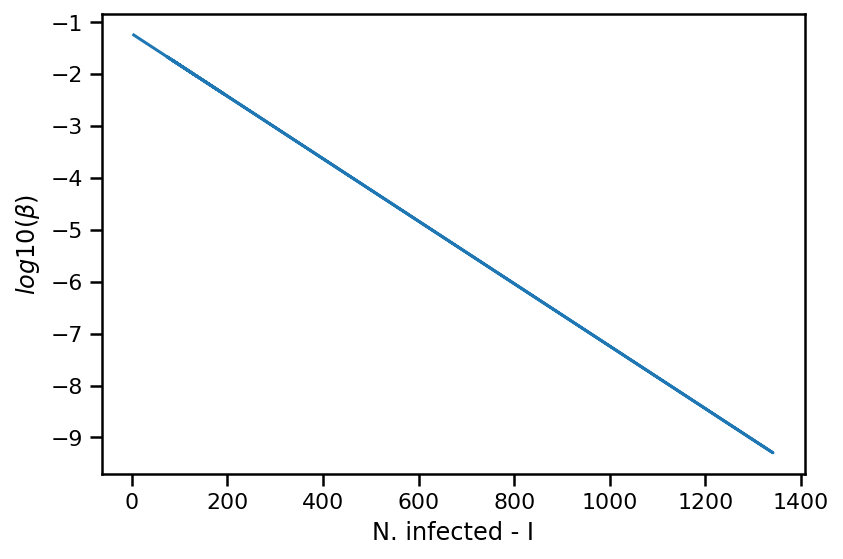

In [13]:
plt.plot(inf_logs,np.log10(beta_logs[1:]))
plt.ylabel(r'$log10(\beta)$');

# plt.plot(inf_logs,beta_logs[1:])
# plt.ylabel(r'$\beta(I)$')

#plt.scatter(inf_logs,beta_logs[1:])


plt.xlabel('N. infected - I')
plt.tight_layout();

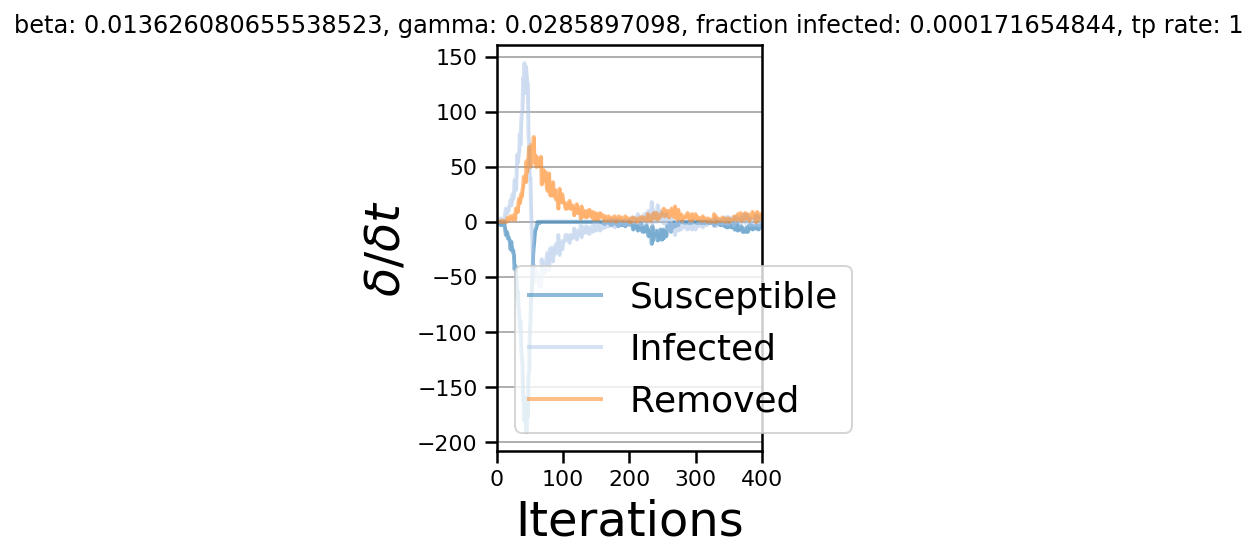

In [44]:
viz = DiffusionPrevalence(model, trends)
# viz.normalized = True
viz.ylabel = r'$\delta/\delta t$'
viz.plot()

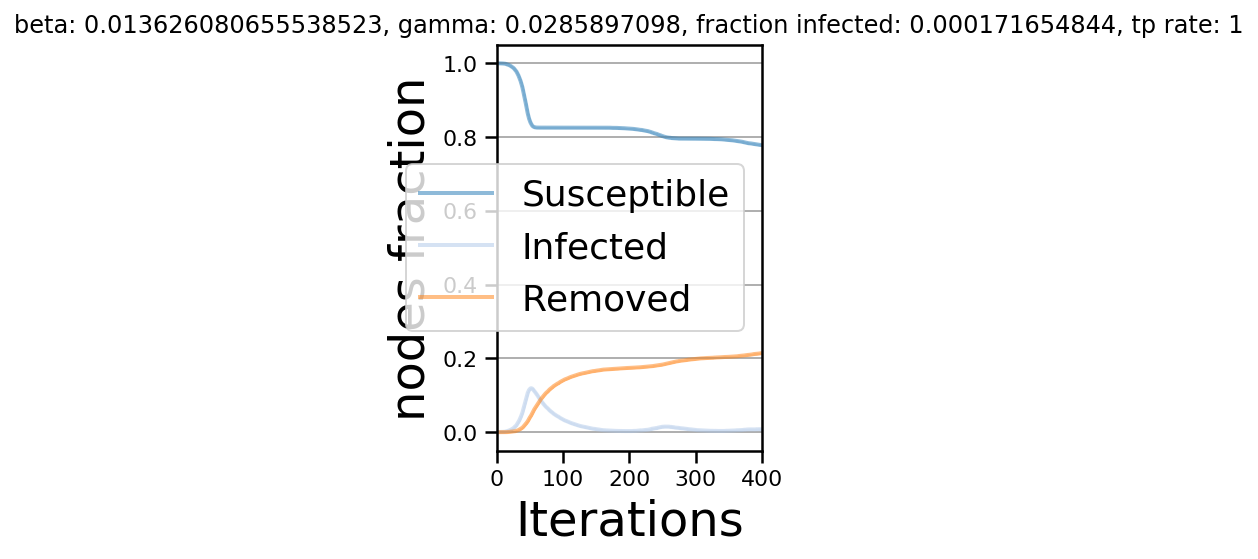

In [45]:
viz = DiffusionTrend(model, trends)
viz.ylabel = 'nodes fraction'
viz.plot()

## plot multi runs

here we plot multiple runs executed in parallel on ICC (cluster from computer science dep.)

In [51]:
N_est = 140000  # estimated pop. in Venice at that time
N_nodes = 20000  # N nodes of the graph used for simulations

In [64]:
# re-load data 
removed_inc = pd.read_csv('./venice_sim_ICC/stoch_behav_SIR_fit_at_city/trends_ER_0.060043_72.147452_32.567777_0.02859_0.000172_N_1800.csv',index_col=0)

print('N simulation runs:',removed_inc.shape[1])

N simulation runs: 1800


compute quality of fit (RMSE / R2)

502
min RMSE: 1481    0.000219
dtype: float64


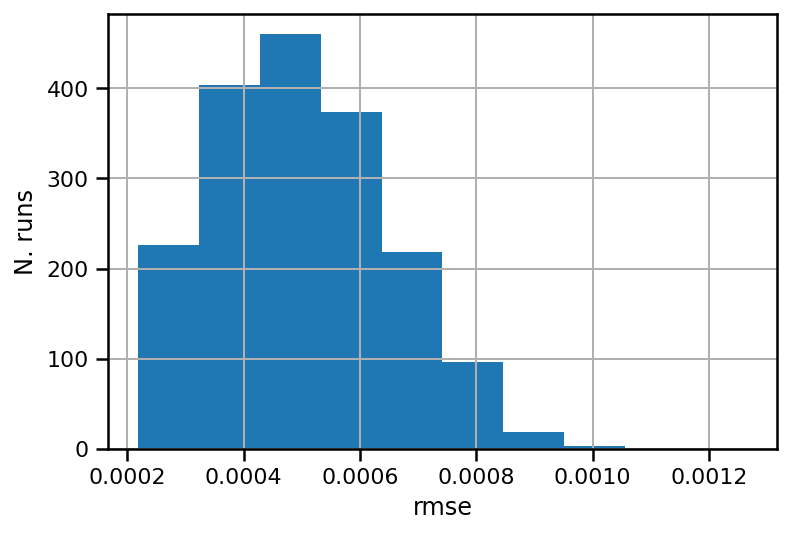

In [58]:
rmse_list = removed_inc.apply(
    lambda x: np.sqrt(mean_squared_error(x / N_nodes, data_to_fit / N_est)))
rmse_list.sort_values(inplace=True)

print(sum(rmse_list < 4e-4))
print('min RMSE:',rmse_list[rmse_list==rmse_list.min()])

rmse_list.hist()
plt.xlabel('rmse')
plt.ylabel('N. runs');

141
max R2: 370    0.900428
dtype: float64


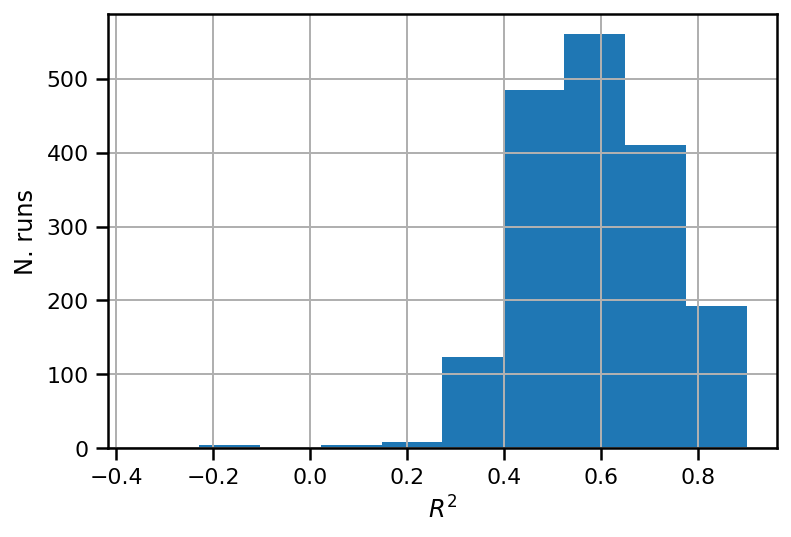

In [59]:
r2_list = removed_inc.apply(
    lambda x: r2_score(x / N_nodes, data_to_fit / N_est))
r2_list.sort_values(inplace=True)

print(sum(r2_list > 0.8))
print('max R2:',r2_list[r2_list==r2_list.max()])

r2_list[r2_list > -1].hist()
plt.xlabel(r'$R^{2}$')
plt.ylabel('N. runs');

plot multiple runs

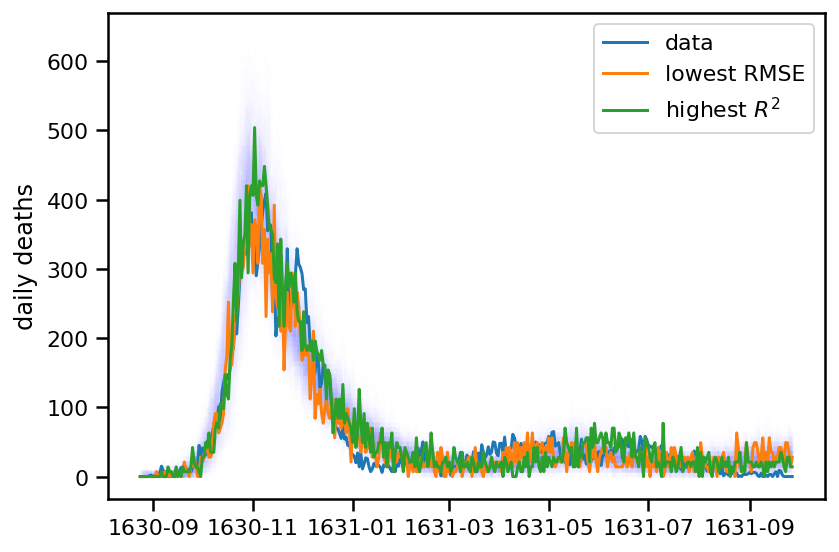

In [63]:
for trace in r2_list[r2_list > 0.8].keys():
    plt.plot(data_to_fit.index,
             removed_inc[trace] / N_nodes * N_est,
             alpha=0.005,
             c='b')

plt.plot(data_to_fit.index, data_to_fit.values, label='data')

plt.plot(data_to_fit.index,
         removed_inc.iloc[:, 1481] / N_nodes * N_est,
         label='lowest RMSE')

plt.plot(data_to_fit.index,
         removed_inc.iloc[:, 370] / N_nodes * N_est,
         label=r'highest $R^{2}$')

plt.ylabel('daily deaths')

plt.legend()
plt.tight_layout()

# EXTRAS

these sections __do not fall into the paper__ , but they were useful for our understanding of disease diffusion on networks

## reproduce small word topology

in this section we briefly want to justify our choice for the value of the rewiring probability of the Watts-Strogatz model, we use throughout the whole notebook

here, besides the usual `average_shortest_path_length` (ASP) and `average_clustering` (clustering coefficient – CC), we also check the __modularity__, as we are interested in community structures 

run simulations for different rewiring probabilities 

In [ ]:
%%time

nnn = 5  # N. nearest neighbours

# lists to store network metrics
cc_list = aspl_list = N_comm_list = modul_list = np.empty(0)

rew_pro_list = np.logspace(-2, 0, num=20)

for rew_pro in rew_pro_list:

    graph = nx.watts_strogatz_graph(
        500, nnn,
        rew_pro)  ## don't go over ~ 500 nodes if you want a 'quick' test

    # compute graph metrics
    cc_list = np.append(cc_list, nx.average_clustering(graph))
    aspl_list = np.append(aspl_list, nx.average_shortest_path_length(graph))
    # compute graph commonuties ...
    my_comm = nx.community.greedy_modularity_communities(graph)
    N_comm_list = np.append(N_comm_list, len(my_comm))
    #... and  modularity
    modul_list = np.append(modul_list, nx.community.modularity(graph, my_comm))

# clean graph var
del graph
gc.collect();

 plot metrics

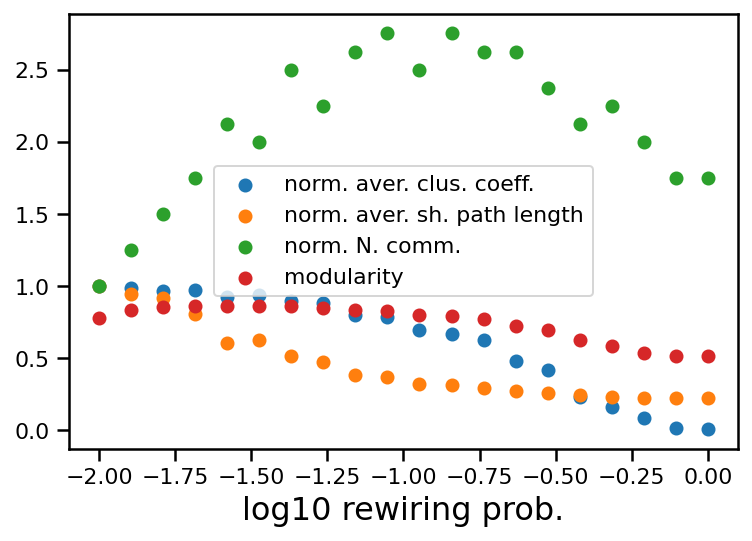

In [23]:
plt.scatter(np.log10(rew_pro_list),
            cc_list / cc_list[0],
            label='norm. aver. clus. coeff.')
plt.scatter(np.log10(rew_pro_list),
            aspl_list / aspl_list[0],
            label='norm. aver. sh. path length')
plt.scatter(np.log10(rew_pro_list),
            N_comm_list / N_comm_list[0],
            label='norm. N. comm.')
plt.scatter(np.log10(rew_pro_list), modul_list, label='modularity')

plt.xlabel('log10 rewiring prob.', size=16)
plt.legend();

as 'signature of phase transition'...we could consider the `rew_pro` that __maximize the N. comm__...

In [20]:
print(max(N_comm_list))
rew_pro_list[np.argmax(N_comm_list)]

22.0


0.08858667904100823

...or that __maximize the modularity__...

In [21]:
print(max(modul_list))
best_rew_pro = rew_pro_list[np.argmax(modul_list)]
best_rew_pro

0.8642589999999001


0.04281332398719394

this numbers of course have some fluctuations...here we choose:

In [9]:
best_rew_pro = 0.04

## graph-topology effect 

graph generation 

In [26]:
# n_nodes = 5247
n_nodes = 500

nnn = 4  # N. nearest neighbours
# %time g = nx.watts_strogatz_graph(n_nodes, nnn, 0.04)

%time g = nx.erdos_renyi_graph(n_nodes, 0.01)

CPU times: user 16.7 ms, sys: 485 µs, total: 17.2 ms
Wall time: 16.9 ms


main network metrics

In [32]:
print('N. edges:', nx.number_of_edges(g))
print('N. nodes:', nx.number_of_nodes(g))
print('N. connected components:', nx.number_connected_components(g))

S = [g.subgraph(c).copy() for c in nx.connected_components(g)]
giant = max(S, key=len)
giant_degrees = list(dict(giant.degree()).values())
print('giant cc size fraction:',
      np.round(giant.number_of_nodes() / g.number_of_nodes(), 3))

print('Average clus. coeff. (giant only!):', nx.average_clustering(giant))

my_comm = nx.community.greedy_modularity_communities(giant)
### ...there are other ways to compute communities -- e.g. # len(nx.community.asyn_lpa_communities(g)) # this is quite slow

print('N. modularity-based-communities (giant only!):', len(my_comm))
print('giant cc. modularity:', nx.community.modularity(giant, my_comm))

N. edges: 1235
N. nodes: 500
N. connected components: 3
giant cc size fraction: 0.996
Average clus. coeff. (giant only!): 0.007899418742792238
N. modularity-based-communities (giant only!): 12
giant cc. modularity: 0.438698880493045


 plot degree distribution

mean degree: 4.94


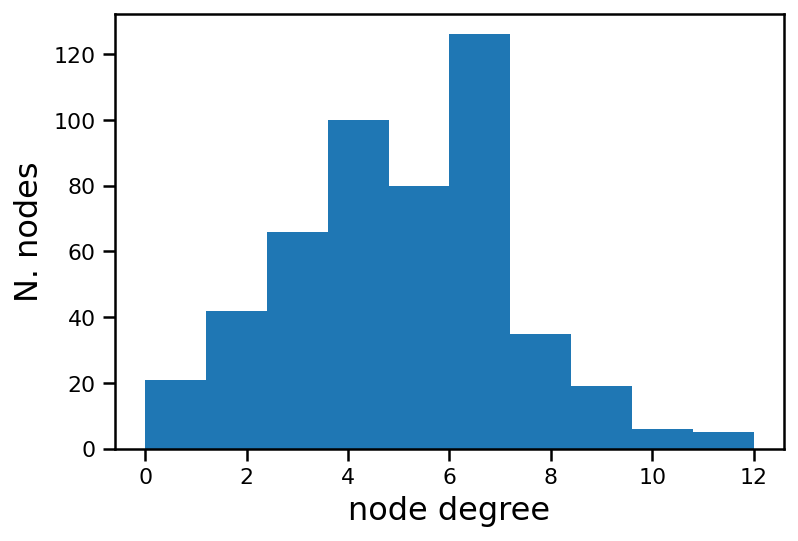

In [31]:
degrees = list(dict(g.degree()).values())
print('mean degree:', np.mean(degrees))
plt.hist(degrees)
plt.xlabel('node degree', size=16)
plt.ylabel('N. nodes', size=16);

loop around epidemiological parameters to compare effect on different graphs

In [33]:
from scipy.stats import variation

In [34]:
import multiprocessing
n_procs = multiprocessing.cpu_count()

# n epidemics sim. runs for each par combination
n_runs = 2 * n_procs

function that tries to optimize computation time in the following loop, by choosing the iteration N (N simulation steps) for the epidemic to finish)

In [36]:
def iter_n_fun(c):

    #     return int(200 * c / (c + 0.1)**2 ) # << good for ER (beta dep.)
    #     return int(5000 * c / (c + 2)**(2) ) # << good for WS (R0 dep.)
    return int(4000 * c / (c + 2)**(2))  # << good for ER (R0 dep.)


# plt.plot(R0_array, [iter_n_fun(counter) for counter in R0_array],
#          marker='.', linestyle='')
# plt.xticks(R0_array)

# plt.plot(beta_array,[iter_n_fun(counter) for counter in beta_array],marker='.',linestyle='')
# plt.xticks(beta_array);

In [37]:
%%time

### arrays for metric on epidemic
# max_inc = time_to_max = np.empty(0)
max_inc_mean = ttm_inc_mean = np.empty(0)
max_inc_std = ttm_inc_std = np.empty(0)
max_epi_size_mean = max_epi_size_std = np.empty(0)
ttm_size_mean = ttm_size_std = np.empty(0)
# counter = 1

### model parameters to keep fixed
# beta = 0.05
gamma = 0.1

R0_array = np.linspace(0.1, 5, num=15)
for R0 in R0_array:

# beta_array = np.linspace(0.01,0.6,12)
# for beta in beta_array:

    ## define network for the  model ##
    model = epidemics.SIRModel(giant)

    cfg = mc.Configuration()
    #     gamma = beta * np.mean(degrees) * (1 + variation(degrees)**2) / R0
    beta = gamma * R0 / (np.mean(giant_degrees) *
                         (1 + variation(giant_degrees)**2))

    cfg.add_model_parameter('beta', beta)  # infection rate
    cfg.add_model_parameter('gamma', gamma)  # recovery rate
    #cfg.add_model_parameter('fraction_infected',1 / giant.number_of_nodes())
    cfg.add_model_parameter('fraction_infected', 0.0025)

    cfg.add_model_parameter('tp_rate', 1)  # 0:mean-field VS 1:full stoch.

    model.set_initial_status(cfg)

    ## ## ## ## run epidemic simulations  ## ## ## ##

    # re-setting the model
    model.set_initial_status(cfg)

    #try to save time on N. iter., while still finishing the epidemics
    iter_n = iter_n_fun(R0)
    #iter_n = iter_n_fun(beta)

    ## run MULTIPLE simulation, for each parameter combination
    trends = multi_runs(
        model,
        execution_number=n_runs,
        iteration_number=iter_n,
        nprocesses=n_procs)

    #     counter += 1

    # check if ALL epidemic runs finished <=> no more infected
    if np.any([t['trends']['node_count'][1][-1] != 0 for t in trends]):

        print('some epidemics did not finish, for R0 {}, on {} timesteps:'.
              format(R0, iter_n))
        #print('some epidemics did not finish, for beta {}, on {} timesteps:'.format(np.round(beta,2),iter_n))
        print([t['trends']['node_count'][1][-1] for t in trends])
        break

    else:

        ## just a visual checkpoint
        print('all went fine for sim. with R0 {} on {} timesteps'.format(R0, iter_n))
        #print('all went fine for sim. with beta {} on {} timesteps'.format(np.round(beta,2),iter_n))

        ## compute epidemiological metrics ##

        # get removed incidence
        removed_inc = pd.DataFrame([t['trends']['status_delta'][2] for t in trends])
        # get total removed
        removed_tot = pd.DataFrame(t['trends']['node_count'][2] for t in trends)

        #  mean/std (over runs) of max incidence
        max_inc_mean = np.append(max_inc_mean, removed_inc.max(axis=1).mean())
        max_inc_std = np.append(max_inc_std, removed_inc.max(axis=1).std())

        #  mean/std (over runs) of  time-to-max incidence
        ttm_inc_mean = np.append(ttm_inc_mean, removed_inc.idxmax(axis=1).mean())
        ttm_inc_std = np.append(ttm_inc_std, removed_inc.idxmax(axis=1).std())

        #  mean/std (over runs) of  max epi size -- the last value is the max as it's growing
        max_epi_size_mean = np.append(max_epi_size_mean,
                                      removed_tot.iloc[:, -1].mean())
        max_epi_size_std = np.append(max_epi_size_std,
                                     removed_tot.iloc[:, -1].std())

        #  mean/std (over runs) of  time-to-max epi. size
        ttm_size_mean = np.append(ttm_size_mean, removed_tot.idxmax(axis=1).mean())
        ttm_size_std = np.append(ttm_size_std, removed_tot.idxmax(axis=1).std())

all went fine for sim. with R0 0.1 on 90 timesteps
all went fine for sim. with R0 1.3250000000000002 on 479 timesteps
all went fine for sim. with R0 2.5500000000000003 on 492 timesteps
all went fine for sim. with R0 3.7750000000000004 on 452 timesteps
all went fine for sim. with R0 5.0 on 408 timesteps
CPU times: user 1.47 s, sys: 561 ms, total: 2.03 s
Wall time: 37.7 s


save results to file

In [ ]:
# summary_df = pd.DataFrame(np.column_stack([max_inc_mean,max_inc_std,ttm_mean,ttm_std]),index=R0_array,
#                           columns=['max_inc_mean','max_inc_std','ttm_mean','ttm_std'])

summary_df = pd.DataFrame(np.column_stack([max_inc_mean, max_inc_std, 
                                           ttm_inc_mean, ttm_inc_std,
                                           max_epi_size_mean, max_epi_size_std, 
                                           ttm_size_mean, ttm_size_std]),
                          index=R0_array,
    #                            index=beta_array,
                          columns=['max_inc_mean', 'max_inc_std', 
                                   'ttm_inc_mean', 'ttm_inc_std',
                                   'max_epi_size_mean', 'max_epi_size_std', 
                                   'ttm_size_mean','ttm_size_std'])

summary_df.index.name = 'R0'
# summary_df.index.name = 'beta'

# summary_df.to_csv('simulations_plots/graph_topology_effect/epi_summary_WS_beta_dep.csv')
# summary_df.to_csv('simulations_plots/graph_topology_effect/epi_summary_ER_beta_dep.csv')

# summary_df.to_csv('simulations_plots/graph_topology_effect/epi_summary_WS_R0_dep.csv')
summary_df.to_csv('simulations_plots/graph_topology_effect/epi_summary_ER_R0_dep.csv')

# summary_df.to_csv('simulations_plots/graph_topology_effect/epi_summary_WS_gamma_dep.csv')
# summary_df.to_csv('simulations_plots/graph_topology_effect/epi_summary_ER_gamma_dep.csv')

summary_df.head()

(*no need to re run* all simulations >>) merge reloaded results and plot

In [44]:
ws_summary = pd.read_csv('simulations_plots/graph_topology_effect/epi_summary_WS_gamma_dep.csv')
er_summary = pd.read_csv('simulations_plots/graph_topology_effect/epi_summary_ER_gamma_dep.csv')

# ws_summary = pd.read_csv('simulations_plots/graph_topology_effect/epi_summary_WS_beta_dep.csv')
# er_summary = pd.read_csv('simulations_plots/graph_topology_effect/epi_summary_ER_beta_dep.csv')

# ws_summary = pd.read_csv('simulations_plots/graph_topology_effect/epi_summary_WS_R0_dep.csv')
# er_summary = pd.read_csv('simulations_plots/graph_topology_effect/epi_summary_ER_R0_dep.csv')

ws_summary['graph'] = 'WS'
er_summary['graph'] = 'ER'

concat_df = pd.concat([ws_summary, er_summary])

# remove temp vars
del ws_summary, er_summary
gc.collect();

In [40]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
for my_graph in concat_df.graph.unique():
    plt.errorbar(
        concat_df[concat_df.graph == my_graph].R0,
        concat_df[concat_df.graph == my_graph].max_inc_mean,
        concat_df[concat_df.graph == my_graph].max_inc_std,
        label=my_graph,
        alpha=0.5)

plt.ylabel('max removed inc.\nmean +/- std')
plt.legend()

plt.subplot(222)
for my_graph in concat_df.graph.unique():
    plt.errorbar(
        concat_df[concat_df.graph == my_graph].R0,
        concat_df[concat_df.graph == my_graph].ttm_inc_mean,
        concat_df[concat_df.graph == my_graph].ttm_inc_std,
        label=my_graph,
        alpha=0.5)
plt.ylabel('time to max removed inc.\nmean +/- std')
plt.legend()

plt.subplot(223)
for my_graph in concat_df.graph.unique():
    plt.errorbar(
        concat_df[concat_df.graph == my_graph].R0,
        concat_df[concat_df.graph == my_graph].max_epi_size_mean,
        concat_df[concat_df.graph == my_graph].max_epi_size_std,
        label=my_graph,
        alpha=0.5)
plt.ylabel('max epi. size.\nmean +/- std')
plt.xlabel('$R_{0} $')
# plt.xlabel('$R_{0} \sim 1/\\gamma $')
# plt.xlabel('$\\beta $')
plt.legend()

plt.subplot(224)
for my_graph in concat_df.graph.unique():
    plt.errorbar(
        concat_df[concat_df.graph == my_graph].R0,
        concat_df[concat_df.graph == my_graph].ttm_size_mean,
        concat_df[concat_df.graph == my_graph].ttm_size_std,
        label=my_graph,
        alpha=0.5)
plt.ylabel('time to max epi. size.\nmean +/- std')
plt.xlabel('$R_{0} $')
# plt.xlabel('$R_{0} \sim 1/\\gamma $')
# plt.xlabel('$\\beta $')
plt.legend()

## save plot
plt.tight_layout()
plt.savefig('simulations_plots/graph_topology_effect/graph_effect_gamma_{}_n_nodes_{}_nnn_{}_R0_dep.pdf'.
            format(gamma, n_nodes, nnn))
# plt.savefig('simulations_plots/graph_effect_beta_{}_n_nodes_{}.pdf'.format(beta,n_nodes))
# plt.savefig('simulations_plots/graph_effect_gamma_{}_n_nodes_{}_beta_dep.pdf'.format(gamma,n_nodes))

plt.close();

## community-structure effect 

In [45]:
import multiprocessing
n_procs = multiprocessing.cpu_count()

# n epidemics sim. runs for each par combination
n_runs = 1 * n_procs

In [47]:
%%time

### set graph properties
# nnn = 5  # N. nearest neighbours -- for WS only
n_nodes = 500

### arrays for graph's metric
# aspl  = []
largest_cc = n_cc = modul = N_comm = np.empty(0)

### arrays for metric on epidemic
# duration  = []
# max_inc = time_to_max = np.empty(0)
max_inc_median = time_to_max_median = np.empty(0)

### set upper threshold for removed, as measure of epidemic duration
# rem_thre = 0.8

prob_array = np.logspace(-2.5, -1.5, num=20)  ## for simplicity, this is also used for both WS and ER graphs

for prob in prob_array:

    ## generate graph
    #     g = nx.watts_strogatz_graph(n_nodes, nnn, prob)
    g = nx.erdos_renyi_graph(n_nodes, prob)

    ## ## ## ## ## compute graph metrics ## ## ## ##
    #     duration = np.append(nx.average_clustering(g))
    #     aspl = np.append(nx.average_shortest_path_length(g))

    ## ##  connected components
    n_cc = np.append(n_cc, nx.number_connected_components(g))
    S = [g.subgraph(c).copy() for c in nx.connected_components(g)]
    giant = max(S, key=len)
    largest_cc = np.append(largest_cc,
                           giant.number_of_nodes() /
                           g.number_of_nodes())  # fraction of largest CC

    ## ## communities and modularities (of giant compo., for ER graph)
    my_comm = nx.community.greedy_modularity_communities(giant)
    N_comm = np.append(N_comm, len(my_comm))

    temp_mod = nx.community.modularity(giant, my_comm)

    # we only consider graph with high modularity, in order to get 'longer' epidemics
    #     if temp_mod > 0.4:
    modul = np.append(modul, temp_mod)

    ## ## ## ## run epidemic simulations  ## ## ## ##

    # re-setting the model
    model = epidemics.SIRModel(g)
    model.set_initial_status(cfg)

    # SINGLE  model run
    #     iterations = model.iteration_bunch(200, node_status=True)
    #     trends = model.build_trends(iterations)

    # max (removed) incidence and time to max incidence
    #     max_inc = np.append(max_inc,max(trends[0]['trends']['status_delta'][2]))
    #     time_to_max = np.append(time_to_max, np.argmax(trends[0]['trends']['status_delta'][2]))

    ## run MULTIPLE simulation, for each parameter combination
    trends = multi_runs(
        model,
        execution_number=n_runs,
        iteration_number=100,
        nprocesses=n_procs)

    ## compute epidemiological metrics ##
    # extract data from sim module
    removed_inc = pd.DataFrame([t['trends']['status_delta'][2] for t in trends])

    # return median (over runs) of max incidence and time-to-max
    max_inc_median = np.append(
        max_inc_median, removed_inc.max(axis=1).median())
    time_to_max_median = np.append(
        time_to_max_median, removed_inc.idxmax(axis=1).median())

CPU times: user 9.27 s, sys: 1.03 s, total: 10.3 s
Wall time: 48.5 s


 viz results 

In [48]:
# summary_df = pd.DataFrame(np.column_stack([max_inc,time_to_max,N_comm,modul,np.log10(rew_pro_array)]),
#                           columns=['max_inc','time_to_max','N_comm','modul','log10(rew_pro)'])

summary_df = pd.DataFrame(np.column_stack([max_inc_median, time_to_max_median, 
                                           modul, N_comm, largest_cc, n_cc,np.log10(prob_array)]),
                          columns=['max_inc_median', 'time_to_max_median', 
                                   'modul_giant', 'N_comm_giant','largest_cc', 'n_cc', 'log10_prob_array'])

sns.pairplot(summary_df)

# plt.savefig('simulations_plots/community_structure_effect/correl_summary_WS_nnn={}_n_runs={}.pdf'.format(nnn,n_runs))
plt.savefig('simulations_plots/community_structure_effect/correl_summary_ER_n_nodes_{}.pdf'.format(n_nodes))
plt.close()

for the ER graph: it seems reasonable to choose p that maximize `time_to_max_median`:

...but in the ER graphs what matters is the product __p*n__

In [51]:
p_for_time_to_max = 10**(summary_df.log10_prob_array[summary_df.time_to_max_median.idxmax])
print(p_for_time_to_max)

pn_best = p_for_time_to_max * n_nodes
pn_best

0.006543189129712969


3.2715945648564846